<center>
<h1>188.980 Advanced Information Retrieval</h1>
<h2>Exercise 2 - Music Information Retrieval</h2>
</center>

**Group Number:** 12

* **Group members:**
 * **Full Name:** Svitlana Vakulenko
   * *Matrikelnummer:* 01525172
   * *Studienkennzahl:* E 786 881

# Introduction

The aim of this exercise is to get insights into music information retrieval practices. You will follow a content based approach which is based on the idea that the semantically relevant information is provided in the audio itself. Thus the aim is to identify and extract this information in a meaningful representation. 

In [12]:
%load_ext autoreload
%autoreload 2

# plotting functions
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import os              # access to operating system functions
import glob            # reg-ex based file-iterator

# scientific computing
import numpy as np     # numerical computing
import pandas as pd    # powerful data processing library

# audio feature extraction
import librosa
from rp_extract import rp_extract

# machine learning
from sklearn.preprocessing import LabelEncoder, StandardScaler
# use pip install -U scikit-learn to update sklearn if this line throws an error
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import LinearSVC

from utility_functions import show_classification_results, plot_confusion_matrix, show_query_results

# misc
import itertools
import progressbar

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Prepare your data

First, please download the specified data-set, extract it locally to your hardisk and specify the full-path to the extracted directory to the *AUDIO_COLLECTION_PATH* variable below

In [13]:
# GTZAN Genre Collection downloaded from http://marsyasweb.appspot.com/download/data_sets/
# The dataset consists of 1000 audio tracks each 30 seconds long
N_SAMPLES = 1000
# tar -xvf genres.tar into the folder:
AUDIO_COLLECTION_PATH = "./dataset/genres/"

**Prepare file-lists and ground-truth labels**

Define the collection of files to process and the corresponding class labels which is also known as *ground truth*.

* create a list of filenames and a list of corresponding labels
  * e.g. use [glob](https://docs.python.org/2/library/glob.html) to iterate over the class directories in the music collection
  * use the names of the subdirectories as label names
  * iterate through all class directories and get all filenames with the extension '.au'
  * store the filename and its corresponding label in the two lists *filenames* and *labels*
  
Take care that both lists are synchronously aligned and that each label corresponds to the right filename.

In [14]:
# fill these lists with values
filenames = []
labels    = []
# iterate over genre subfolders
for subdir in glob.glob(AUDIO_COLLECTION_PATH+'*'):
    genre = subdir.split('/')[-1]
    
    # get all filenames with the extension '.au'
    genre_files = glob.glob(subdir+'/*.au')
    filenames.extend(genre_files)
    labels.extend([genre]*len(genre_files))
    
    print genre, len(genre_files)
    assert len(filenames) == len(labels)
assert len(filenames) == N_SAMPLES

blues 100
classical 100
country 100
disco 100
hiphop 100
jazz 100
metal 100
pop 100
reggae 100
rock 100


# Music Feature Extraction

*Feature extraction* is a crucial part of content-based approaches. The goal is to transform and reduce the information provided by the digital audio signal into a set of semantically descriptive numbers. A typical CD quality mainstream radio track has an average length of three minutes. This means, that song is digitally described in Pulse-code Modulation (PCM) by 15.9 million numbers (3 [minutes] x 60 [seconds] x 2 [stereo channels] x 44100 [sampling rate]). Using CD-quality 16bit encoding this information requires 30.3MB of memory. Besides music specific reasons, the computational obstacles concerned with processing of huge music collections make raw audio processing a suboptimal solution. Feature design and implementation tries to overcome technological obstacles of digital audio and to extract essential music properties that can be used to analyze, compare or classify music. 

You will use the common music features as descriptors for timbre \cite{logan2000mel}, rhythm \cite{lidy10_ethnic} or general spectral properties \cite{tzanetakis2000marsyas,lartillot2007matlab}.



* iterate over all audio files
    1. load audio data using the [librosa.core.load](http://librosa.github.io/librosa/generated/librosa.core.load.html) function. The feature extractors you will use expect a mono signal as input, so take care to appropriately load or convert the audio data.<br><br>
    2. extract music features<br><br>
        2.1. [Mel-frequency cepstral coefficients (MFCC)](http://librosa.github.io/librosa/generated/librosa.feature.mfcc.html) (librosa): extract 12 coefficients using a FFT-window size of 1024 samples with 50% overlap (this corresponds to a hop-length of 512 samples). To correctly calculate the coefficients the samplerate of the audio file has to be provided.<br>
         2.2. [Pitch-classes / Chroma](http://librosa.github.io/librosa/generated/librosa.feature.chroma_stft.html) (librosa): extract the chroma features using a FFT-window size of 1024 samples with 50% overlap, similar to the MFCCs. Also supply the correct samplerate.<br>
         2.3. The features extracted using the libros-library are provided on a frame-level. They are calculated for each FFT-window and thus the results are lists of feature vectors. The machine learning algorithms you will be using expect a single-vector per instance. Thus, the extracted feature vectors need to be aggregated into a single-vector representation. You will be using the simple approach of just calculating their mean and standard-deviations. Perform the following operations for the *MFCC* and *chroma* features:
      * use the numpy functions *mean* and *std* to calculate the statistical moments of the extracted features along the appropriate axis.
      * use the numpy function *concatenate* to concatenate the statistical moments into a single vector
  
    2.4. *Statistical Spectrum Descriptors* and *Rhythm Patterns*: use the following code to extract the psychoaccoustic feature-sets. The function returns a dictionary of extracted features. The Statistical Spectrum Descriptors are stored using the key 'ssd' and the Rhythm Patterns using the key 'rp'. The features are already single vectors so no post-processing is required.

                rp_features = rp_extract(wave_data, 
                                         samplerate, 
                                         extract_ssd = True, 
                                         extract_rp  = True,
                                         skip_leadin_fadeout = 0, 
                                         verbose     = False)

    3. append the extracted features to the dictionary embedded lists which are provided above.<br><br>
    4. finally iterate over the dictionary keys and convert the lists of extracted feature-vectors into feature-spaces by converting them into numpy arrays using the numpy *asarray* function.

  
The feature extraction will take about 30 minutes

In [18]:
# Fill these lists with values
audio_features = {}
audio_features["mfcc"]   = []
audio_features["chroma"] = []
audio_features["ssd"]    = []
audio_features["rp"]     = []

# progressbar visualization widget to estimate processing time
pbar = progressbar.ProgressBar()

# iterate over all files of the collection
for audio_filename in pbar(filenames):
    
    # 1. load audio
    print audio_filename
    y, sr = librosa.core.load(path=audio_filename, mono=True)
    # 2. extract features
    # - 2.1. mfcc
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=12, n_fft=1024, hop_length=512)
    # - 2.2. chroma
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=1024, hop_length=512)
    # -- 2.3. aggregate frame based mfcc and chroma vectors into single feature vectors
    # https://docs.scipy.org/doc/numpy/reference/generated/numpy.mean.html
    mfcc_means = np.mean(mfcc, axis=1)
    print mfcc_means
    mfcc_means = [np.mean(frame) for frame in mfcc]
    print mfcc_means
    mfcc_stds = [np.std(frame) for frame in mfcc]
    print mfcc_stds
    mfcc_stds = np.std(mfcc, axis=1)
    print mfcc_stds
    mfcc = np.concatenate([mfcc_means, mfcc_stds])
    
    chroma_means = np.mean(chroma, axis=1)
    assert len(chroma_means) == 12
    chroma_stds = np.std(chroma, axis=1)
    assert len(chroma_stds) == 12
    chroma = np.concatenate([chroma_means, chroma_stds])
    # - 2.4. ssd, rp
    rp_features = rp_extract(y, 
                              sr, 
                              extract_ssd = True, 
                              extract_rp  = True,
                              skip_leadin_fadeout = 0, 
                              verbose     = False)
    
    # 3. append to provided lists
    audio_features["mfcc"].append(mfcc)
    audio_features["chroma"].append(chroma)
    audio_features["ssd"].append(rp_features['ssd'])
    audio_features["rp"].append(rp_features['rp'])
    
# # 4. convert lists of vectors to numpy arrays
for key, feature_list in audio_features.items():
    audio_features[key] = np.asarray(feature_list)

./dataset/genres/blues/blues.00000.au
[-186.42893815  123.14277902  -18.49030039   42.77266255   -6.32015115   18.86452025  -13.69496821   15.37229291  -12.51889186   10.99388735   -8.24782407    8.89079861]
[-186.42893815099674, 123.14277902173399, -18.490300385850286, 42.772662548471949, -6.3201511457564754, 18.864520248330074, -13.694968205772348, 15.372292910424617, -12.51889185929317, 10.993887345572418, -8.2478240655637407, 8.890798613672656]
[52.125980162440293, 18.385005537553727, 16.063756554143357, 12.850903006870551, 13.469784582387925, 10.212465019186238, 9.2266480601702092, 9.0541747982601155, 9.8642151429145528, 8.5451016587900597, 8.4981683733059654, 8.065694675551244]
[ 52.12598016  18.38500554  16.06375655  12.85090301  13.46978458  10.21246502   9.22664806   9.0541748    9.86421514   8.54510166   8.49816837   8.06569468]
./dataset/genres/blues/blues.00001.au
[-280.26802479  126.09278671   10.66920832   35.88654608    3.70809456   21.23916559   -7.91043164   23.2422983

[-252.85255776  142.26375605  -20.71564578   24.77473414  -16.56755023    3.39051135  -12.79035719    4.83219002   -3.33871133   -1.58978241   -2.24031809    1.89967653]
[-252.85255775916758, 142.26375604890731, -20.715645781687392, 24.774734140686537, -16.567550234571058, 3.3905113485288667, -12.7903571902406, 4.8321900242049063, -3.3387113254768606, -1.5897824073399498, -2.2403180907748812, 1.8996765328024743]
[94.46127251814697, 34.774481404834638, 35.463578690236581, 23.632483408323605, 17.901641467716892, 13.285990177241557, 13.055745642314946, 9.6904951321494632, 11.607022501610412, 9.1472348919065904, 8.3833480748151104, 8.41580453506044]
[ 94.46127252  34.7744814   35.46357869  23.63248341  17.90164147  13.28599018  13.05574564   9.69049513  11.6070225    9.14723489   8.38334807   8.41580454]
./dataset/genres/blues/blues.00011.au
[-360.63997597  129.41497205    9.53049366   35.93187361    3.76626761   16.33485768   -2.35959038    9.7195426     2.0946287     6.80557563   -4.3396

[-304.87539282  127.39801645    9.48916355   40.27198217    1.12615298   17.8872075    -6.64955005    8.84748569  -18.42813668   14.08513889   -4.16342188    2.83772378]
[-304.87539281772035, 127.39801645002773, 9.4891635499117157, 40.271982168310743, 1.1261529750835868, 17.887207504509675, -6.6495500491961446, 8.8474856889894564, -18.428136683120645, 14.0851388903406, -4.1634218833998444, 2.8377237793415571]
[56.126586803781478, 21.453857742994717, 24.999088963301542, 13.922657962603505, 11.49101595389895, 10.987715773046729, 9.5884392471620217, 8.9739172828460632, 8.5018949890073419, 9.1439925233589943, 9.1516730450219299, 9.3075054692741794]
[ 56.1265868   21.45385774  24.99908896  13.92265796  11.49101595  10.98771577   9.58843925   8.97391728   8.50189499   9.14399252   9.15167305   9.30750547]
./dataset/genres/blues/blues.00021.au
[-336.84516888  142.05308653   14.93140616   48.18537159   14.28909249   20.57870422    2.66096681    1.23739765  -16.03281327   15.75948087    3.14286

./dataset/genres/blues/blues.00030.au
[-272.97075866  127.99473505   28.91867921   32.08500881    1.6299735    21.47429132  -18.95199724   20.2865446   -23.0223449     4.15382043  -15.6580717    -5.8868817 ]
[-272.97075865601818, 127.99473504533908, 28.918679211770868, 32.085008814659211, 1.6299735017962622, 21.474291315763658, -18.951997235054076, 20.286544597564177, -23.022344896566214, 4.1538204299867321, -15.65807169503285, -5.8868817002514735]
[46.263476622892107, 28.31207784588161, 17.417216979120713, 16.570931899522723, 14.631617275884087, 12.930492293349486, 15.67290718604046, 12.430575803048718, 15.244151089209121, 11.029421463625589, 9.0193767358914823, 8.5764201027308626]
[ 46.26347662  28.31207785  17.41721698  16.5709319   14.63161728  12.93049229  15.67290719  12.4305758   15.24415109  11.02942146   9.01937674   8.5764201 ]
./dataset/genres/blues/blues.00031.au
[-287.91717547  120.94931181   23.63713714   33.83550929    4.57411799   23.63829814  -19.525464     13.00304334

[-183.05728478   92.76246146   -0.87089915   73.79048729  -11.36949555   38.51553269  -12.95488098   20.41357062  -16.23854241   12.47211478  -20.81618523    5.70457649]
[-183.05728478030409, 92.762461462260021, -0.87089915232050219, 73.790487292411996, -11.369495549529008, 38.515532692237706, -12.95488097522226, 20.41357062012867, -16.238542412088663, 12.472114782104223, -20.816185227650529, 5.7045764941122421]
[38.989702479591884, 16.723058942685139, 15.908111722022891, 11.543695520679265, 11.845878233810746, 8.9195318883229096, 9.8581108331006, 7.8388932826648023, 7.7054265804911557, 10.523164449992752, 7.2163835405075991, 7.8248107751869256]
[ 38.98970248  16.72305894  15.90811172  11.54369552  11.84587823   8.91953189   9.85811083   7.83889328   7.70542658  10.52316445   7.21638354   7.82481078]
./dataset/genres/blues/blues.00041.au
[-178.18866731   90.32071088   -1.89277027   55.4254924    -7.14146717   38.20614444   -5.95954735   28.4170971   -19.18322955   13.1680785   -18.0965

[-156.20685139  107.97020319  -23.57262328   56.95868353    0.8552436    34.60958112  -10.6859935    20.05365789  -11.26868664   14.14303243  -10.476315     11.65651107]
[-156.20685139239737, 107.97020318972938, -23.572623283777077, 56.958683526337325, 0.8552435977402244, 34.609581121599263, -10.685993498486337, 20.053657887644814, -11.268686641540377, 14.143032428835596, -10.476314995448645, 11.656511069180137]
[51.249968373550715, 18.868006059283168, 19.298881159811888, 14.806677711587072, 12.49395349093901, 9.5496568981270258, 10.568358921695822, 8.2396677766866979, 8.5925476252601758, 8.5493140693672274, 7.4408665104727687, 7.9697560296466907]
[ 51.24996837  18.86800606  19.29888116  14.80667771  12.49395349   9.5496569   10.56835892   8.23966778   8.59254763   8.54931407   7.44086651   7.96975603]
./dataset/genres/blues/blues.00051.au
[-128.46656829  115.7832842   -34.27128396   64.85946452   -6.01406476   14.60611472  -15.32223011   18.20934561   -8.99755644   20.80913388   -5.63

[-140.60038095  111.84026991  -32.39142167   60.86229226    1.20252924   29.86807076  -12.10098154   20.02619227  -12.58488583   15.54603399   -5.86569646   11.24291034]
[-140.60038095009614, 111.84026991319307, -32.391421669564537, 60.862292261942045, 1.2025292391536653, 29.86807076462744, -12.100981537305644, 20.026192265576892, -12.584885827393675, 15.546033989783036, -5.8656964597359895, 11.242910344666395]
[41.851775967447523, 18.505722247243185, 15.73197033489901, 15.581943760270065, 13.66640555790647, 11.479859918543278, 11.266173416867829, 10.357115762928244, 8.1835473028660175, 9.3794866341524248, 6.9563716896198358, 7.9411562430916671]
[ 41.85177597  18.50572225  15.73197033  15.58194376  13.66640556  11.47985992  11.26617342  10.35711576   8.1835473    9.37948663   6.95637169   7.94115624]
./dataset/genres/blues/blues.00061.au
[-154.3843075    96.33046616  -25.05819773   75.1035522   -26.75524586   35.39367519  -19.4299385    25.09006806  -14.82468621   11.33163387  -12.5219

[-206.66913419  110.3183348   -19.52358403   42.53631184  -26.38900985   18.99827555  -25.69617957   19.5081395   -14.35322309    7.14218084   -9.75066549    7.26570979]
[-206.66913419493775, 110.3183347965209, -19.523584028917661, 42.536311842315342, -26.389009851424998, 18.998275550715011, -25.696179566232544, 19.508139501602578, -14.353223089447642, 7.1421808400304547, -9.7506654880337784, 7.265709788508973]
[47.905200296796977, 29.227776434348726, 18.69969499342222, 13.082006948505404, 14.11707712459387, 10.504952427575478, 15.91201651588694, 10.924216563447592, 10.776022714188148, 9.290584464518771, 10.730315366440992, 9.0134658318483201]
[ 47.9052003   29.22777643  18.69969499  13.08200695  14.11707712  10.50495243  15.91201652  10.92421656  10.77602271   9.29058446  10.73031537   9.01346583]
./dataset/genres/blues/blues.00071.au
[-159.42544841   96.47977005  -13.05144493   55.11201526  -33.77078244   18.70961468  -20.67321385   12.98125506  -13.33779286   15.45109456  -14.045699

[-126.73560657  121.44969865  -32.57993647   36.99120521  -15.15050276   22.25214367  -14.10879565   17.96888232   -8.90973653   11.18936112  -11.41707662   11.10897137]
[-126.73560656525888, 121.4496986522778, -32.579936465813063, 36.991205206031289, -15.150502762087742, 22.252143671617709, -14.108795648660873, 17.968882316582739, -8.9097365340631516, 11.18936111767659, -11.417076621554402, 11.108971374010434]
[51.271520285190839, 21.647281346125261, 16.829419895961308, 14.44112158736565, 13.341671112472753, 11.606797448443791, 15.223949704986598, 10.53550249904556, 11.965443079003728, 9.5958023802865338, 9.6311190943257632, 8.4166817074277276]
[ 51.27152029  21.64728135  16.8294199   14.44112159  13.34167111  11.60679745  15.2239497   10.5355025   11.96544308   9.59580238   9.63111909   8.41668171]
./dataset/genres/blues/blues.00081.au
[ -97.16225645  109.19607394  -45.3786033    39.93656959  -21.31062358   24.53642114  -18.27602029   14.96591295  -14.7257416    11.55815096  -15.2436

[-249.94846454  121.31505288   11.98794475   54.50859782    8.22948859   28.08724708   -8.2201897    20.4641247   -14.2395675     5.97020241   -5.16280491    1.37400829]
[-249.94846453638092, 121.31505287816549, 11.987944746135788, 54.508597821341375, 8.229488589259125, 28.087247081636345, -8.2201896984871272, 20.464124703540762, -14.239567498868086, 5.9702024140237677, -5.1628049108528691, 1.3740082928006012]
[69.441604172732099, 38.496933764731118, 26.946513543260505, 18.677955822900984, 18.612296438325981, 13.81878205565123, 14.266729198263027, 11.231778496710328, 13.066318453831736, 11.021843413364339, 11.338862793617158, 12.034812246374248]
[ 69.44160417  38.49693376  26.94651354  18.67795582  18.61229644  13.81878206  14.2667292   11.2317785   13.06631845  11.02184341  11.33886279  12.03481225]
./dataset/genres/blues/blues.00091.au
[-308.69249167  166.59535349    3.18634726   26.99595743   12.66936254   20.46193745    2.7694615    14.35338779    2.06267508   10.61711395   -2.3895

./dataset/genres/classical/classical.00000.au
[-334.11058358  141.22942376  -32.93945643   24.12991066  -13.97817409   17.78143746   -9.75086207    5.60792092  -14.03271867    7.3161189    -4.12079658    7.5026947 ]
[-334.1105835757989, 141.22942375977502, -32.939456429593307, 24.129910659622595, -13.978174090540643, 17.781437462024726, -9.750862070273083, 5.6079209205534264, -14.032718669645527, 7.316118903004277, -4.1207965753620339, 7.5026946979091846]
[42.915672390387563, 14.708794523301131, 15.677704260694572, 13.723934316878696, 9.5147156802524346, 9.683020464980066, 11.595616398927369, 9.3071128562015861, 9.5285172098173714, 13.933299677889112, 11.238374810273767, 9.7939736484164648]
[ 42.91567239  14.70879452  15.67770426  13.72393432   9.51471568   9.68302046  11.5956164    9.30711286   9.52851721  13.93329968  11.23837481   9.79397365]
./dataset/genres/classical/classical.00001.au
[-385.95972152  143.01651597  -24.65355647   23.26521161  -14.5098757    17.57558787   -6.415019

[-381.14547609  133.74847219  -27.25043609   29.50723021  -10.03321391    6.54512242  -11.01335855    0.18905089   -9.24805796    6.01380723   -2.81794487    8.05212779]
[-381.14547608686848, 133.74847218741786, -27.250436087758292, 29.507230210787036, -10.033213911504101, 6.5451224162484083, -11.013358550323986, 0.18905088949744392, -9.2480579612522238, 6.0138072330317698, -2.8179448702269663, 8.0521277919250256]
[79.451612493845531, 16.606558192777303, 23.484818131242644, 11.708849235782392, 12.795858940395167, 12.491184889576424, 10.420043509338056, 12.728652497684461, 11.617552808137731, 10.904146458550098, 14.075296916416407, 13.943065368396413]
[ 79.45161249  16.60655819  23.48481813  11.70884924  12.79585894  12.49118489  10.42004351  12.7286525   11.61755281  10.90414646  14.07529692  13.94306537]
./dataset/genres/classical/classical.00011.au
[-448.66010864  184.35177979   -6.89539268   23.18467071    4.54419287   -5.5187226    -7.43251568   -7.73661477   -4.47269542    4.41104

./dataset/genres/classical/classical.00020.au
[-367.14865545  167.69986251  -23.20978548   26.83322348   -4.3647547     1.27748318  -12.53298284   -0.81036945   -7.67027784    5.81455215   -7.90583563   -1.07334619]
[-367.14865545143789, 167.69986250540927, -23.209785476302869, 26.833223478586664, -4.3647546974608922, 1.2774831791963572, -12.532982843368426, -0.81036945310960329, -7.6702778430675913, 5.8145521470240853, -7.9058356339744549, -1.0733461886602944]
[72.912641604259321, 30.794968517111229, 18.508507493781156, 13.829258284698069, 11.859063412717559, 9.3368099639251838, 10.313465085219374, 10.40224638012022, 9.1775574755286442, 9.791995023412742, 11.861248450919726, 12.245017363995903]
[ 72.9126416   30.79496852  18.50850749  13.82925828  11.85906341   9.33680996  10.31346509  10.40224638   9.17755748   9.79199502  11.86124845  12.24501736]
./dataset/genres/classical/classical.00021.au
[-347.38131741  153.02726649  -31.17835901   20.38997006  -10.72743086   -6.34065607  -14.3

[-383.13079539  154.95200825  -29.04088477   22.94816239   -9.31752442  -10.37464651  -16.01611341   -3.99525574   -7.75332035   -0.33831182  -11.82426984   -8.08442766]
[-383.13079539314651, 154.9520082515397, -29.040884772260394, 22.948162394711424, -9.317524421936703, -10.374646510220161, -16.016113405455329, -3.9952557391197865, -7.7533203484152491, -0.33831182122759906, -11.824269844531946, -8.0844276557854471]
[63.757335386367565, 22.689742476876543, 21.249179871220857, 8.0551312251490774, 15.606618646692564, 8.1252654237008208, 10.117428907575, 8.9821265167069892, 10.554319336384209, 8.8645512284990318, 8.2735292973183654, 9.1436990892379413]
[ 63.75733539  22.68974248  21.24917987   8.05513123  15.60661865   8.12526542  10.11742891   8.98212652  10.55431934   8.86455123   8.2735293    9.14369909]
./dataset/genres/classical/classical.00031.au
[-446.85725636  174.56168397    9.31147371   20.15669314    7.08235803    1.34251313   -6.35252885   -1.5365149     0.19387761    0.876187

[-423.48015196  135.20129221  -29.96131486   18.22606461  -12.3386475    -2.36189854  -12.14488091    0.79436633   -4.29689863    1.85692687   -9.29802698   -8.1708784 ]
[-423.48015196284922, 135.20129221146638, -29.961314861845384, 18.226064610958112, -12.338647500038261, -2.3618985416346465, -12.144880913859961, 0.79436632668146545, -4.2968986269321583, 1.8569268673443271, -9.2980269797712545, -8.1708783996748373]
[75.341775008135912, 27.85727888310948, 25.94618801608836, 11.554203606752495, 14.568118814320568, 10.497344001530411, 11.790658426859723, 8.6195344171213275, 11.865460700883068, 9.1564138363927992, 9.3418796257590433, 8.4285013927504746]
[ 75.34177501  27.85727888  25.94618802  11.55420361  14.56811881  10.497344    11.79065843   8.61953442  11.8654607    9.15641384   9.34187963   8.42850139]
./dataset/genres/classical/classical.00041.au
[-432.0934979   132.74378415  -32.77297242   15.28225352   -1.39629576   -7.58464783  -12.98467081   -5.96353751   -6.33178056   -2.20503

[-515.55409872  156.01400679  -11.11228468   42.89717537    4.44869945    2.54388362   -2.27199848   -1.92105199   -2.47643298   -4.33629228   -9.6989697    -1.48884118]
[-515.55409872230507, 156.014006789603, -11.112284676661067, 42.897175365753881, 4.448699447691288, 2.5438836179331861, -2.2719984823500932, -1.9210519909776289, -2.4764329799027394, -4.336292279634069, -9.6989696982629479, -1.488841184785394]
[68.965092297365942, 22.413664349147538, 12.175290091114476, 7.4118254191933941, 7.259345964807995, 5.7999524822429258, 6.6700934153872433, 7.0835864006894687, 6.3763699569646421, 5.3844243860511956, 5.7226611241967582, 6.1792855956043446]
[ 68.9650923   22.41366435  12.17529009   7.41182542   7.25934596   5.79995248   6.67009342   7.0835864    6.37636996   5.38442439   5.72266112   6.1792856 ]
./dataset/genres/classical/classical.00051.au
[-299.70164098  121.63123388    1.11692239   29.31166984   10.8081709    16.8187552     5.2233536     6.2212755     0.88777205    5.80474283  

[-235.58780246  126.69665604  -30.78567189   17.07099369   -5.14512968   -1.69672399   -8.82490493   -3.90687673   -5.91395363   -3.53599411   -5.71304911   -4.70855791]
[-235.58780245723662, 126.69665604046595, -30.785671893277502, 17.070993694851381, -5.1451296844978351, -1.6967239900257032, -8.8249049316892361, -3.9068767293795932, -5.9139536302829452, -3.5359941075963373, -5.7130491145797917, -4.7085579066776724]
[58.818099105544931, 27.264552482842152, 15.582886545063921, 8.5447432631796794, 7.6392336514992731, 7.5825252063569257, 6.5197829813844184, 6.622036027781415, 7.2153909172949007, 7.520816547757061, 8.2602554389466682, 7.062068972811967]
[ 58.81809911  27.26455248  15.58288655   8.54474326   7.63923365   7.58252521   6.51978298   6.62203603   7.21539092   7.52081655   8.26025544   7.06206897]
./dataset/genres/classical/classical.00061.au
[-341.51998545  153.33955002  -18.62686244   21.24176271    7.49509515    3.69304626   -1.97062136   -5.59704316   -4.95213503   -5.97732

./dataset/genres/classical/classical.00070.au
[-387.26055437  142.24406917  -16.92623777   21.88578135   -0.48613123   -4.21236095   -0.3209299    -2.20448769   -2.58649551   -0.57712664   -3.39120493   -0.14733457]
[-387.2605543714609, 142.24406916960322, -16.926237772019974, 21.885781350462583, -0.48613122913003937, -4.2123609520764624, -0.32092989544569545, -2.2044876856859412, -2.5864955137772703, -0.57712663800307706, -3.3912049292988429, -0.14733456855691979]
[87.861330886558704, 25.80924245848836, 19.111708965395938, 10.465529580334632, 10.029795932506607, 8.2203756566114681, 7.9832551975482566, 8.353353497775716, 9.7858995652408378, 10.337843690131498, 9.162265829269451, 10.94441144064475]
[ 87.86133089  25.80924246  19.11170897  10.46552958  10.02979593   8.22037566   7.9832552    8.3533535    9.78589957  10.33784369   9.16226583  10.94441144]
./dataset/genres/classical/classical.00071.au
[-336.79424953  142.5114593   -23.83481437   26.42217235   -0.41964567   -6.17370437   -2

[-617.81244352  161.52053383    8.63782255   34.84594144   11.63620929    4.52593161    3.53029549   -3.762268      1.78764406    3.10305207    2.31178228    3.46222768]
[-617.81244352488966, 161.52053383020976, 8.6378225541059344, 34.845941443936823, 11.636209294583546, 4.5259316118884936, 3.5302954902707087, -3.7622680013138732, 1.7876440554994075, 3.1030520662584751, 2.3117822826905936, 3.4622276763882609]
[90.417433192249845, 41.943754373307158, 23.948173196181148, 9.9529335470285876, 9.6339457488482356, 10.000922351836977, 10.521284297437958, 9.7291337689582864, 8.1813073633279956, 6.771960768490179, 7.331764598516135, 6.0115698454489879]
[ 90.41743319  41.94375437  23.9481732    9.95293355   9.63394575  10.00092235  10.5212843    9.72913377   8.18130736   6.77196077   7.3317646    6.01156985]
./dataset/genres/classical/classical.00081.au
[-439.59687091  159.87780729  -19.6597532    19.94723696    6.13198231   -4.41998005   -2.62836667   -2.62577829   -3.76123618   -3.87160284   -

[-390.03181839   94.16080764  -42.60529041   28.95554903  -22.2967174     8.14215376  -18.26354296    8.77307226   -9.10294192   25.4049669     5.90256646   15.27909927]
[-390.03181838658935, 94.160807638859836, -42.605290405480879, 28.955549028814062, -22.29671740237638, 8.1421537567163647, -18.263542959595895, 8.7730722593046622, -9.1029419208510376, 25.404966898087867, 5.9025664626028362, 15.279099268743218]
[36.847647049688561, 20.332960686008299, 13.217850091376407, 9.8812339359868435, 10.435310150212116, 8.3339640095725489, 8.3108556755961729, 8.9042674885435495, 10.672915377646476, 14.720048257316778, 13.213895607651629, 15.061696796245025]
[ 36.84764705  20.33296069  13.21785009   9.88123394  10.43531015   8.33396401   8.31085568   8.90426749  10.67291538  14.72004826  13.21389561  15.0616968 ]
./dataset/genres/classical/classical.00091.au
[-314.96681968   98.06457416  -39.60285209   37.56304587  -12.82880734   21.35871191   -6.03411608   26.15018885   -5.26835191   13.24451946

[-90.520566    76.20373829   7.03254603  29.39310828  14.46915541   6.17178861   4.42598883   8.47826102   3.84976275   9.65721586  -1.25238416   2.83695141]
[-90.5205659989536, 76.203738286101597, 7.0325460265028559, 29.393108279690036, 14.469155406581592, 6.1717886108183055, 4.4259888263348053, 8.47826101544306, 3.8497627459191426, 9.65721585653408, -1.252384156694238, 2.8369514127329198]
[31.156781456119202, 20.083558976263902, 16.156843642195192, 11.842668341208487, 11.127808587011275, 10.718403122936936, 10.014394770583372, 8.600638450800961, 8.4170785465162616, 8.8945343730531565, 9.3432797540980737, 7.3879818635685872]
[ 31.15678146  20.08355898  16.15684364  11.84266834  11.12780859  10.71840312  10.01439477   8.60063845   8.41707855   8.89453437   9.34327975   7.38798186]
./dataset/genres/country/country.00001.au
[-76.88962859  65.83270063   0.84891783  28.67815847  10.63748147   9.81098401   5.95286208  10.52131045   4.11110428   9.53580617   1.08038822   7.19872822]
[-76.889

[-267.11924435  112.79683681   -0.76660672   39.06383128    0.9815063    -0.36890425   -2.21015834    0.99495407   -8.45460913   -4.04226559   -3.4525663    -2.95421329]
[-267.1192443457964, 112.79683681096625, -0.76660671709019534, 39.063831279432598, 0.98150629878801399, -0.36890425214760425, -2.2101583449989999, 0.99495407245345591, -8.4546091292012022, -4.042265587686459, -3.4525663017220714, -2.9542132947003199]
[66.509008091264519, 31.952499043609897, 24.743292109864747, 18.408706641061038, 18.342918296930819, 13.842411541616739, 12.740599143685282, 10.372996661790379, 13.603267080138931, 13.681304341772474, 11.039870427348921, 11.005635537372171]
[ 66.50900809  31.95249904  24.74329211  18.40870664  18.3429183   13.84241154  12.74059914  10.37299666  13.60326708  13.68130434  11.03987043  11.00563554]
./dataset/genres/country/country.00011.au
[-267.48113492   68.29353494   12.6555646    24.91110264   11.37342187    0.90142213    8.64538838    1.85585784   -4.23266401   10.245309

[-232.71684163   82.7042716    26.89806743   47.38774383    6.10806884   25.2029939    -0.66927228   10.35798239   -7.08193813    5.41106558   -0.19003608    2.40738376]
[-232.71684162886757, 82.704271604489492, 26.898067432636115, 47.387743827442215, 6.1080688363124986, 25.202993899690902, -0.6692722774947063, 10.357982394788465, -7.0819381333648073, 5.4110655766632014, -0.19003607507495726, 2.407383757397954]
[73.89489608999672, 38.39078786526855, 15.986247515115059, 19.48258418786261, 15.515147066556864, 10.655169345689576, 11.705601964869839, 9.1666784269081756, 11.506025229131717, 12.024964394603392, 7.8696085367524393, 9.2884634724053026]
[ 73.89489609  38.39078787  15.98624752  19.48258419  15.51514707  10.65516935  11.70560196   9.16667843  11.50602523  12.02496439   7.86960854   9.28846347]
./dataset/genres/country/country.00021.au
[-278.29198774  172.05193056  -17.08120024   38.0367284    11.40931992    4.49204644   -4.53918646   -3.53330595   -4.92535762   -2.92636841   -5.5

[-341.91134559  135.650071     44.51668283   36.90584097   11.56021979    8.05961701   -6.95822626   -8.41476673   -8.17855447   -4.45821287   -6.05366362   -2.77918713]
[-341.91134559011613, 135.65007100115676, 44.516682832691345, 36.905840974618826, 11.560219794358172, 8.0596170103849705, -6.9582262560394534, -8.414766729502988, -8.1785544723610872, -4.4582128691915326, -6.0536636154167782, -2.7791871255711507]
[61.070305990142487, 30.361402771577811, 17.55006895605602, 10.57511287603935, 11.60306774572898, 11.366735645740501, 11.108789112281457, 9.7543100573556529, 10.43140868011943, 9.9246371920616507, 10.720812602937023, 12.175843707568987]
[ 61.07030599  30.36140277  17.55006896  10.57511288  11.60306775  11.36673565  11.10878911   9.75431006  10.43140868   9.92463719  10.7208126   12.17584371]
./dataset/genres/country/country.00031.au
[-196.17927853  112.23979375  -17.24268121   34.0357054     3.8739245    -2.99992054   -0.84398608   -2.18316038   -4.45856453    4.65820616   -3.

[-176.11404345   89.05651834   -2.89288552   31.09704453    2.9295255    -2.04405977    4.62282976    3.81560238   -4.19570074   -1.54966943   -4.05190892   -1.29192814]
[-176.11404344816276, 89.05651834137565, -2.8928855215377896, 31.097044528513504, 2.9295254970993372, -2.0440597718772602, 4.6228297557594926, 3.815602383207426, -4.1957007366603243, -1.5496694321039088, -4.0519089242460087, -1.2919281424911151]
[58.777242200479108, 22.901391370594915, 19.311828204299477, 15.225502179039488, 15.661428494980441, 12.104579365949125, 11.04055466668723, 8.7909320253053682, 9.6254374690928692, 8.70881504951595, 8.4769742884781252, 8.4165071807587086]
[ 58.7772422   22.90139137  19.3118282   15.22550218  15.66142849  12.10457937  11.04055467   8.79093203   9.62543747   8.70881505   8.47697429   8.41650718]
./dataset/genres/country/country.00041.au
[-182.78261766   87.56966788   15.22470426   34.23196225   24.49106366    0.29523325   12.85533594    4.79311625   -4.8028789     4.31553455    1.

[-212.64417554  127.72437706  -11.90563508   47.04006655  -13.65465193   22.99036239  -11.39938279   18.90005066  -13.09397702   16.71737004  -11.13688676   10.27561487]
[-212.64417554249346, 127.72437706219613, -11.905635080911395, 47.040066552660399, -13.654651931298707, 22.99036239219291, -11.399382786887664, 18.900050655037028, -13.093977018449023, 16.717370035020181, -11.136886759714205, 10.275614874508838]
[49.941738243111075, 27.139720662852994, 19.767645323447628, 14.656439762490855, 14.004891504298055, 11.508240296350335, 12.056172603565217, 10.292398623113652, 12.895211898280927, 11.311094899604143, 9.5298757200436075, 8.7880733043384005]
[ 49.94173824  27.13972066  19.76764532  14.65643976  14.0048915   11.5082403   12.0561726   10.29239862  12.8952119   11.3110949    9.52987572   8.7880733 ]
./dataset/genres/country/country.00051.au
[-269.83494567  130.7107316   -15.50940762   46.21644119   -2.96052751   17.33853335  -14.54260776   15.95643427  -18.81041599   11.15583065  -

[-245.82797708  136.27997101   15.19591544   47.47997776    3.95153357   23.64179173   -4.00012536   22.81666465   -9.43293286   14.28670736   -5.03786962    9.10636865]
[-245.82797708202861, 136.27997100529774, 15.19591544112342, 47.479977760280342, 3.9515335735265396, 23.641791734059158, -4.0001253641327521, 22.816664646264961, -9.4329328623520077, 14.286707363668542, -5.0378696221379986, 9.1063686487643132]
[60.988920265661299, 31.904586340281075, 15.717211649459907, 11.800457335677297, 13.252660566598689, 10.679164447474568, 10.113137289845469, 10.545477751152664, 14.962735374073107, 12.221611045637991, 11.38265176605112, 9.6596208758410764]
[ 60.98892027  31.90458634  15.71721165  11.80045734  13.25266057  10.67916445  10.11313729  10.54547775  14.96273537  12.22161105  11.38265177   9.65962088]
./dataset/genres/country/country.00061.au
[-252.76735599  143.69264222    8.64012486   46.11154021   -5.93799368   21.67620757  -13.18862226   17.00601589  -12.81801571    9.99811533   -7.

[-169.7517204   123.80256021  -29.04475206   40.02319135  -15.08079434   27.94608247  -10.86128948   14.05369005  -10.46220382   10.68038186   -8.44410099    8.40089225]
[-169.75172040137679, 123.80256020948792, -29.04475206447443, 40.023191351927188, -15.080794337914151, 27.946082466256094, -10.861289478770608, 14.053690049725365, -10.462203819005524, 10.680381859387163, -8.4441009888288576, 8.4008922477523402]
[53.765503578329955, 26.359776375054317, 16.659967363388731, 16.392654401105879, 12.737217870684306, 13.985203706839899, 11.939325379393518, 9.4059963392050552, 9.7387843379780552, 10.157580363560051, 9.6826712604136755, 9.4104579326006288]
[ 53.76550358  26.35977638  16.65996736  16.3926544   12.73721787  13.98520371  11.93932538   9.40599634   9.73878434  10.15758036   9.68267126   9.41045793]
./dataset/genres/country/country.00071.au
[-252.46098656  162.15641305  -23.05412451   20.16266921   -4.97200248   -1.20248089   -4.61762301   -5.49289681  -15.99475792   -0.00953986  -

[-172.02014165  116.88696379  -10.70042507   43.47879793   -5.21154653   27.75197008   -7.29251626   18.82082061  -21.2535774    16.8957247   -16.89084837   11.09043035]
[-172.02014165260769, 116.88696378801494, -10.700425065092853, 43.478797931319349, -5.211546525961352, 27.751970081108112, -7.2925162646045392, 18.820820607611033, -21.253577396949176, 16.895724700243431, -16.890848370433929, 11.090430351706186]
[55.352310807526941, 29.644229741707957, 22.366617705433129, 13.735102638247421, 14.900210483674032, 12.554281484838766, 15.229873704614228, 11.38528820909784, 9.9907124814382477, 10.638401689596549, 8.8854064492491833, 7.481318425413491]
[ 55.35231081  29.64422974  22.36661771  13.73510264  14.90021048  12.55428148  15.2298737   11.38528821   9.99071248  10.63840169   8.88540645   7.48131843]
./dataset/genres/country/country.00081.au
[-146.06348676  111.44207804  -19.28480593   46.83178056   -6.02723688   17.13212165  -20.30437914   14.53603545  -15.94635442   15.48836622  -14

[-161.65171724  120.07954949  -29.12194743   51.74178563   -4.71910023   16.42893557  -15.74231353   13.24910162  -12.98686303   15.74864977  -12.26786345   10.41417196]
[-161.65171724146819, 120.07954948732524, -29.121947427477064, 51.741785625315359, -4.7191002339485948, 16.428935568401261, -15.742313527393836, 13.249101617094439, -12.986863034330179, 15.748649769504777, -12.26786345319411, 10.414171955516458]
[42.604337588461291, 25.440703856726333, 15.867764384895963, 15.248811703066485, 15.801619859688303, 10.700997723563795, 11.688933422795753, 10.009935628021157, 10.476216465925921, 10.45738113595023, 9.1135327457727282, 8.7570773026235322]
[ 42.60433759  25.44070386  15.86776438  15.2488117   15.80161986  10.70099772  11.68893342  10.00993563  10.47621647  10.45738114   9.11353275   8.7570773 ]
./dataset/genres/country/country.00091.au
[-260.44394913  131.12373674  -18.22340622   45.80236133   -1.58748775   12.06674391   -5.74485514   10.04223523  -10.11462289    5.38668369   -

[-188.17482025   99.02741601   14.09339167   17.03723811    7.5516782    14.92635663   -1.43767996    6.70164553    1.14254385   -1.30650924   -3.26059085   -5.02693314]
[-188.17482024813546, 99.027416007153718, 14.093391668614224, 17.037238109892691, 7.5516782021835018, 14.926356630368559, -1.4376799616631277, 6.7016455286704444, 1.1425438523542371, -1.3065092368024434, -3.2605908546355789, -5.02693314250065]
[68.158045523891886, 41.911104717550138, 25.395920174597684, 15.467618542477789, 12.976503786652991, 12.692385192236618, 11.443369006452231, 10.050865095137901, 8.7139614892896216, 8.3808623048991162, 9.7126912306950217, 9.4512865962553718]
[ 68.15804552  41.91110472  25.39592017  15.46761854  12.97650379  12.69238519  11.44336901  10.0508651    8.71396149   8.3808623    9.71269123   9.4512866 ]
./dataset/genres/disco/disco.00001.au
[-103.44636189   55.31049502   -5.6044874    22.68306177    8.6800133    18.81494157    7.27693001    6.65808174    0.92131101   11.24294943   -1.892

[-80.05257604  61.57490997 -15.90097367  27.43046749   7.33142397  15.83900745   4.09704077  11.19630346   0.12590912   9.7149051    3.53883283   5.2462485 ]
[-80.052576044163729, 61.574909972927429, -15.900973665361933, 27.430467490795589, 7.3314239690114809, 15.839007445208862, 4.0970407734876257, 11.196303460333812, 0.12590912469254045, 9.7149051030515068, 3.5388328266206868, 5.2462484978573647]
[35.320928022947825, 21.330454680622573, 18.104852582169677, 12.107069683680802, 13.067324328956268, 10.615833496662637, 10.894910152260639, 9.2136878426202546, 8.762184111721016, 8.419025292647726, 7.9685906734693219, 8.8773828423361802]
[ 35.32092802  21.33045468  18.10485258  12.10706968  13.06732433  10.6158335   10.89491015   9.21368784   8.76218411   8.41902529   7.96859067   8.87738284]
./dataset/genres/disco/disco.00011.au
[-115.39375007   64.89610757    9.77337098   13.30334518    6.44936179    9.38325049    4.11276499   15.30623751    1.5970017     9.02036335   -2.64448342   -7.332

./dataset/genres/disco/disco.00020.au
[-176.506717    111.98418459  -13.54490384   36.17837479  -11.26864481   15.88169112   -6.69165088    8.13042547   -3.62344205    1.32590825   -9.7398047     0.13943337]
[-176.50671699614901, 111.98418458679558, -13.544903843129273, 36.178374789287446, -11.268644808713393, 15.88169111721704, -6.6916508835036232, 8.1304254704471539, -3.6234420537321723, 1.3259082497564028, -9.7398047047623137, 0.13943337180581267]
[57.174004702599731, 39.794757456561364, 21.53156172713949, 16.217499548781841, 14.908698584823043, 10.242623967719167, 9.6203826484346013, 9.5153026183591347, 9.0203581734422524, 9.5569878351506361, 9.2621197441253837, 8.6624778502471997]
[ 57.1740047   39.79475746  21.53156173  16.21749955  14.90869858  10.24262397   9.62038265   9.51530262   9.02035817   9.55698784   9.26211974   8.66247785]
./dataset/genres/disco/disco.00021.au
[-189.775858     75.63419774   32.22154903   11.86333949   13.12223252    3.83674829    2.23996398    5.29785

./dataset/genres/disco/disco.00030.au
[-114.62357581   65.68853766    6.42545485   17.76975392   11.97147826    9.02422037    4.35974704    5.80694147   -0.17624558    0.26429038    3.01946064   -1.36684339]
[-114.62357581180943, 65.688537658712136, 6.4254548454568976, 17.769753919201101, 11.971478264994168, 9.0242203734023647, 4.3597470350707557, 5.8069414688488648, -0.17624558396041998, 0.26429038415760492, 3.0194606373680641, -1.3668433915188249]
[48.885864879198749, 23.329052782463801, 16.047548790385715, 16.289780597496989, 14.768694020210411, 10.535520182332, 10.36643507559924, 8.872001001651304, 8.477297851111123, 9.119164319743799, 7.9184766429850084, 7.2257261348038124]
[ 48.88586488  23.32905278  16.04754879  16.2897806   14.76869402  10.53552018  10.36643508   8.872001     8.47729785   9.11916432   7.91847664   7.22572613]
./dataset/genres/disco/disco.00031.au
[-139.16061425   60.77939276   -6.59784971   15.53481395    5.22871703    7.46839675    3.92020122   -3.67629091   -

[-153.51641026   82.49128438   -7.2960709    24.87213751   -4.28261971   16.46043191    6.45588921    1.20892517    0.13708088    6.49184841    1.84767813    2.56213267]
[-153.5164102631864, 82.49128438371163, -7.2960708956915976, 24.872137506014361, -4.2826197145742997, 16.460431913194565, 6.455889213826727, 1.208925174294893, 0.13708088436921037, 6.4918484093251454, 1.8476781279381402, 2.5621326688514485]
[54.676498229321936, 27.357830243912439, 17.795679335501582, 17.116987275829672, 14.089774174319647, 10.059920250336326, 12.432298937821029, 10.893581670411423, 10.694141023083084, 8.797984185617576, 9.0337081478274452, 8.4721691475095859]
[ 54.67649823  27.35783024  17.79567934  17.11698728  14.08977417  10.05992025  12.43229894  10.89358167  10.69414102   8.79798419   9.03370815   8.47216915]
./dataset/genres/disco/disco.00041.au
[-189.92299214  125.57069513   30.95647834   25.29559434   11.08337918   -1.06985454    0.00058137    0.73826035   -1.84007411   -1.28248681    0.3774231

./dataset/genres/disco/disco.00050.au
[-118.72823015  103.54480703  -31.66440354   33.89320999  -17.02488046   31.66325766  -14.76919685   21.69706741  -14.81826205   18.8279139   -11.68378047   16.58388851]
[-118.72823015248511, 103.54480703315406, -31.664403540972295, 33.893209990854828, -17.024880459339485, 31.663257657067529, -14.769196854374686, 21.697067406485335, -14.818262050715473, 18.827913901762269, -11.68378047248774, 16.583888512597685]
[39.573368387594279, 20.324042986438556, 17.72158193123985, 13.075484930191308, 11.705845866757699, 9.9519012903070827, 10.941981559777409, 7.7852746235439332, 8.1085422597527526, 9.1533246763704099, 7.7416590419674209, 7.366467848833004]
[ 39.57336839  20.32404299  17.72158193  13.07548493  11.70584587   9.95190129  10.94198156   7.78527462   8.10854226   9.15332468   7.74165904   7.36646785]
./dataset/genres/disco/disco.00051.au
[-150.3390689    90.83810156  -33.62391784   38.1749598   -21.4044874    30.34004797  -15.19188066   21.6705984

./dataset/genres/disco/disco.00060.au
[-195.12014107  120.60141409  -21.29349424   45.08327239   -2.44967147   29.44776031  -10.69844375   21.07497442  -15.15480754   15.76861946   -9.00481448    7.15447216]
[-195.1201410663073, 120.6014140875965, -21.293494244417968, 45.083272390010741, -2.4496714723729771, 29.447760307252125, -10.698443749459756, 21.074974421970911, -15.154807539783027, 15.76861946282769, -9.004814482215421, 7.1544721634111159]
[62.829188219546396, 27.934275184048726, 21.335818758658942, 12.38499381572395, 12.551815394976019, 11.027811471606276, 10.345416076378998, 9.2672916531339915, 9.7059297233841306, 8.0509374124566353, 9.2729876736060692, 7.7849341214587602]
[ 62.82918822  27.93427518  21.33581876  12.38499382  12.55181539  11.02781147  10.34541608   9.26729165   9.70592972   8.05093741   9.27298767   7.78493412]
./dataset/genres/disco/disco.00061.au
[-172.33754257   92.21108229    0.65241111   33.31146344  -16.15001927   17.27763637  -13.35711684   16.17635295 

./dataset/genres/disco/disco.00070.au
[-155.10434804   99.08270132  -27.33714199   36.31015147  -16.83338124   30.01614396  -15.05668125   20.62731915  -14.99560731   17.49764056  -11.99321886   15.14049097]
[-155.10434803670665, 99.082701320760449, -27.337141989851069, 36.310151471719301, -16.833381237593187, 30.016143957643393, -15.056681247576281, 20.627319147697836, -14.99560731331781, 17.497640555113321, -11.993218862741761, 15.140490973587703]
[43.68637758326912, 20.131710621819426, 17.693147671236972, 12.994449803696284, 11.776307886305041, 9.9172793537755801, 10.871477795250218, 7.8333772283828651, 8.0478212336089303, 9.0064181559629528, 7.6356766021180995, 7.0757444340643083]
[ 43.68637758  20.13171062  17.69314767  12.9944498   11.77630789   9.91727935  10.8714778    7.83337723   8.04782123   9.00641816   7.6356766    7.07574443]
./dataset/genres/disco/disco.00071.au
[-177.7570122    80.71542849  -13.91980714   40.9721244   -11.98263402   23.36831275  -19.49298481   27.046333

./dataset/genres/disco/disco.00080.au
[-295.17583056   97.91851955   16.97280701   49.32457537   -6.29891626   15.23830418  -14.46926778   21.0688613   -19.28662217   13.47228227  -14.50277123    4.77326589]
[-295.17583056276453, 97.91851954815624, 16.972807007546042, 49.32457536603512, -6.298916255583987, 15.238304177238424, -14.469267779439948, 21.068861304092245, -19.286622170565671, 13.472282265827717, -14.502771226174509, 4.7732658871973657]
[59.423182102576376, 26.40121153118665, 23.004261305299291, 16.741045831261403, 12.03484847283187, 17.924919692352081, 11.682027886764395, 9.5345993645523404, 11.414735315985281, 10.883348840347786, 9.9140180733087249, 9.3922451217476883]
[ 59.4231821   26.40121153  23.00426131  16.74104583  12.03484847  17.92491969  11.68202789   9.53459936  11.41473532  10.88334884   9.91401807   9.39224512]
./dataset/genres/disco/disco.00081.au
[-268.01803042   89.88910369  -17.10951221   38.04764761   -1.37707563   16.1627618    -6.5321263    15.07811594  

./dataset/genres/disco/disco.00090.au
[-200.23391012   87.87584378  -15.36344808   41.11921434   -8.37840891   27.36565317  -18.2883999    18.96336035  -15.34622155   14.04469364   -7.11323113   11.63668266]
[-200.23391011906116, 87.87584378455449, -15.363448081140707, 41.119214335319143, -8.3784089107399531, 27.365653174477625, -18.288399901957632, 18.963360354258381, -15.346221550646211, 14.044693638826036, -7.1132311287525196, 11.636682660501808]
[47.800097021053716, 25.775025240276214, 20.01577713765996, 15.130461578461048, 12.379781130980872, 11.110373799307748, 10.391782955710283, 9.2399815069532583, 8.8321199715366934, 8.6625300252802298, 8.367171645645449, 7.7731408153595121]
[ 47.80009702  25.77502524  20.01577714  15.13046158  12.37978113  11.1103738   10.39178296   9.23998151   8.83211997   8.66253003   8.36717165   7.77314082]
./dataset/genres/disco/disco.00091.au
[-192.43655869  101.98014789  -17.32776347   44.95148774    5.69835739   28.78291783    0.15011053   14.0389510

./dataset/genres/hiphop/hiphop.00000.au
[-162.63644516   85.90061853  -31.05887072   33.44808797  -19.3990903    22.81745591  -21.04044026   19.83001402  -15.99717064   18.35968651  -12.25659665   10.59173772]
[-162.63644515787661, 85.900618531731027, -31.058870717054685, 33.448087971847784, -19.399090297579139, 22.81745591233879, -21.040440256999595, 19.830014019162142, -15.997170635500192, 18.359686509390816, -12.256596645467743, 10.591737718066971]
[78.492214354512925, 30.511346900636745, 24.526610610090994, 20.945345579087427, 14.34200055231889, 12.917432197371861, 11.204167054605303, 11.164128878517436, 11.099799220262227, 8.8952325298823745, 10.151899852778595, 8.3727926361851885]
[ 78.49221435  30.5113469   24.52661061  20.94534558  14.34200055  12.9174322   11.20416705  11.16412888  11.09979922   8.89523253  10.15189985   8.37279264]
./dataset/genres/hiphop/hiphop.00001.au
[-161.30418026   54.84873879   -9.42590394   62.01319094    8.58088657   30.12521418   -4.73183025   33.77

./dataset/genres/hiphop/hiphop.00010.au
[-143.67592548   92.79363427  -37.92577185   37.48990211  -11.31752298   36.76093818  -11.49460497   18.1888375    -7.50606058   18.24296255   -6.08331603    9.6701249 ]
[-143.67592547548301, 92.793634266609928, -37.925771848864088, 37.489902112799292, -11.317522979289393, 36.760938183865001, -11.494604971440909, 18.188837495431915, -7.5060605812629291, 18.242962549591066, -6.0833160309050971, 9.6701248986371198]
[40.151654628360433, 22.817089104640246, 17.549711668677816, 14.610177701291279, 13.294149892336945, 10.770382813538658, 11.201410737992633, 9.5787581873581154, 9.4074105624454845, 8.8923844048741376, 8.6980118589598838, 8.3657635047557939]
[ 40.15165463  22.8170891   17.54971167  14.6101777   13.29414989  10.77038281  11.20141074   9.57875819   9.40741056   8.8923844    8.69801186   8.3657635 ]
./dataset/genres/hiphop/hiphop.00011.au
[-152.48854838  102.81621066   -5.56401347   50.47149393   -7.43768106   21.84441513  -14.61952078   19.

[-202.29954583   52.77161308  -27.41474575   68.97900384   -6.05336099   33.60649623   -6.84354936   23.74409077   -4.55224043   22.17259594   -4.42102269   14.40457538]
[-202.29954582526076, 52.771613079990132, -27.414745750570109, 68.979003835196067, -6.0533609893911802, 33.60649622935037, -6.8435493631284476, 23.744090771811425, -4.5522404332279001, 22.172595937518025, -4.4210226868131812, 14.404575375414973]
[72.351945986075066, 33.168877285895569, 29.382996734799519, 22.527305333703456, 18.175900377991589, 13.881273868404557, 16.877201870352749, 12.302869570107868, 13.538711188323681, 11.870859783745782, 12.151182107064354, 10.527354344451064]
[ 72.35194599  33.16887729  29.38299673  22.52730533  18.17590038  13.88127387  16.87720187  12.30286957  13.53871119  11.87085978  12.15118211  10.52735434]
./dataset/genres/hiphop/hiphop.00021.au
[-102.51466613   93.18111094  -18.29103091   49.80986645  -13.93372727   22.82706737  -16.53288692   23.33383808  -14.81489925   15.57619685   -9

./dataset/genres/hiphop/hiphop.00030.au
[-100.40552194   41.84858035   32.19856419   27.6483449     5.54368654   23.15872464    3.663265      7.85198736   -0.27509592    5.58179535    1.46204841    3.17400283]
[-100.40552193898348, 41.84858034716558, 32.198564189709124, 27.648344902774422, 5.5436865363580328, 23.158724638246607, 3.6632650043846007, 7.8519873630019106, -0.27509592300189661, 5.5817953463911536, 1.4620484133377487, 3.1740028313012165]
[42.813099540915204, 18.871838483962318, 18.292341330370665, 13.500435958638644, 12.400898763693787, 10.12358604590211, 9.2311884315094108, 7.2288127701932305, 8.5125740757160635, 7.1071824553227119, 6.9289594793346669, 6.1232052867886857]
[ 42.81309954  18.87183848  18.29234133  13.50043596  12.40089876  10.12358605   9.23118843   7.22881277   8.51257408   7.10718246   6.92895948   6.12320529]
./dataset/genres/hiphop/hiphop.00031.au
[-98.76766492  62.03309175  -2.27060458  16.00538177   6.71250342   5.92088023  15.67218527   3.73137969   5.

[-255.02581583  102.05535796   46.93413553   12.91954647    4.89697791   -4.42736384    1.26680685  -10.85586095   -4.06141782    5.5339538    -0.14757064    8.89354918]
[-255.02581582552071, 102.05535795754871, 46.934135529460931, 12.919546470225283, 4.8969779094919117, -4.4273638403059339, 1.2668068549719371, -10.855860947149438, -4.0614178196534274, 5.533953802855816, -0.14757063709279081, 8.8935491754251164]
[98.378884862358618, 48.175665737734356, 28.034578424551636, 17.851590689380611, 16.08859389389864, 16.243050713154041, 14.954686038981899, 12.732888001774917, 12.449910132256418, 12.464472647920076, 11.991352601105802, 12.182620869782175]
[ 98.37888486  48.17566574  28.03457842  17.85159069  16.08859389  16.24305071  14.95468604  12.732888    12.44991013  12.46447265  11.9913526   12.18262087]
./dataset/genres/hiphop/hiphop.00041.au
[-154.54122134   68.54071811    1.42804878   31.95496351    4.28053065    6.06465325    4.03227228    3.96491441    6.51922862    5.25991925    4.

./dataset/genres/hiphop/hiphop.00050.au
[-193.04940721  114.50877845   22.25621338   40.37301954   29.87531006    2.57100074   16.95272392    2.30401024    8.88439442   -2.3032861     9.15273135    0.6725778 ]
[-193.04940720716203, 114.50877844715501, 22.256213375240055, 40.373019542686649, 29.875310059081485, 2.571000742896421, 16.952723921362882, 2.3040102354699474, 8.8843944232236964, -2.3032860974952221, 9.1527313519340048, 0.67257779978834586]
[69.543253818202629, 36.902961577242294, 28.844675978535477, 18.602164524634297, 18.758370274634451, 15.168145338625648, 13.688186893860877, 11.368926419905923, 10.266424667692036, 10.853219041031899, 9.7964263583364364, 8.8300686962843713]
[ 69.54325382  36.90296158  28.84467598  18.60216452  18.75837027  15.16814534  13.68818689  11.36892642  10.26642467  10.85321904   9.79642636   8.8300687 ]
./dataset/genres/hiphop/hiphop.00051.au
[-155.53885107   76.12243227   23.31100055   51.34717003    4.39810421   18.90842826    2.32851674    8.7810

[-232.00307802   94.82601011  -12.56681012   59.91140257   10.31306444   20.33367339   14.64237623   12.80174668    9.26466826   14.28248524    6.75489676    8.12354096]
[-232.00307802492597, 94.826010113031529, -12.566810118114409, 59.91140257284232, 10.313064442976671, 20.333673386722779, 14.642376234497814, 12.801746678953673, 9.2646682581393538, 14.28248523901229, 6.7548967648730978, 8.1235409639748468]
[75.437258514423689, 23.630964049534722, 27.526353681023725, 19.550757860507627, 17.437888605751201, 12.284072973882468, 12.080057987639711, 10.327749670664883, 9.2631836655287234, 10.726560817389261, 9.2808292873435683, 8.5863758717084355]
[ 75.43725851  23.63096405  27.52635368  19.55075786  17.43788861  12.28407297  12.08005799  10.32774967   9.26318367  10.72656082   9.28082929   8.58637587]
./dataset/genres/hiphop/hiphop.00061.au
[-203.95830754   96.50872533  -10.57597459   38.41520689   21.60328867   24.20411031    8.47292837   10.24041871    8.86033287    5.51548102    6.8863

[-160.47754515   85.23669405   57.02440614   29.37191401   17.02765691   20.64023858    9.53179931    7.35991837    1.34434045    1.23068736    2.01207452    2.3979051 ]
[-160.47754515182743, 85.236694048506166, 57.024406135469476, 29.371914012305844, 17.027656914345442, 20.640238582260068, 9.5317993081402914, 7.3599183667591044, 1.3443404514964883, 1.2306873640504072, 2.0120745176210804, 2.3979051039836223]
[74.958571867862361, 35.336634345864134, 29.625540260001976, 18.053373189418082, 15.151064896481802, 10.334073522248374, 9.5481454313492939, 8.6073274962358806, 9.4204792630801339, 8.4535147214212927, 7.7802821714828676, 7.1971156465870036]
[ 74.95857187  35.33663435  29.62554026  18.05337319  15.1510649   10.33407352   9.54814543   8.6073275    9.42047926   8.45351472   7.78028217   7.19711565]
./dataset/genres/hiphop/hiphop.00071.au
[-153.62294003   52.79365898   45.43576332   32.48578065   21.66119229    8.00481608    8.91148619    8.01440688   -3.2663507     5.46007233    5.330

./dataset/genres/hiphop/hiphop.00080.au
[-143.50624044   50.47277468    9.64090673   29.8885366     7.96351278    1.86506416    4.21580781    4.67596616    1.68276748    1.85232188    1.18576827   -4.74854949]
[-143.50624044297075, 50.472774680264045, 9.6409067255703107, 29.88853659731442, 7.9635127821653153, 1.8650641617113775, 4.2158078059388684, 4.6759661598927336, 1.682767480295112, 1.8523218762574627, 1.1857682660193178, -4.7485494904192098]
[51.60157475646151, 28.700313003450322, 23.132478982069582, 17.588984117119995, 15.08107616732398, 12.97795462567148, 11.917804039760661, 11.103832445099135, 12.00886838349536, 9.9487790400520808, 9.5653163487050339, 9.5525382271391042]
[ 51.60157476  28.700313    23.13247898  17.58898412  15.08107617  12.97795463  11.91780404  11.10383245  12.00886838   9.94877904   9.56531635   9.55253823]
./dataset/genres/hiphop/hiphop.00081.au
[-292.21537877  124.08264887    4.0040969    39.36062508   10.57389303   24.95764615   -2.2414532    17.84777661  

./dataset/genres/hiphop/hiphop.00090.au
[-185.49419748   95.94947157  -19.91143297   38.28927682   -3.5283327    28.90199173  -13.63281061   24.76697256   -8.01916499   20.53211845  -11.05004283   18.4566353 ]
[-185.4941974775677, 95.949471574561301, -19.911432969262158, 38.289276822715564, -3.5283326997991487, 28.901991728727978, -13.632810610880874, 24.766972562082664, -8.0191649899277255, 20.532118452979233, -11.050042834326884, 18.456635303383212]
[32.604523405246091, 16.869807179754432, 15.730990545565213, 11.749405737325171, 11.376420342850034, 9.4262140169515352, 11.756190538296352, 9.2545916433885065, 9.460692224345788, 8.3918382320820726, 8.5262931364689525, 7.95471325447713]
[ 32.60452341  16.86980718  15.73099055  11.74940574  11.37642034   9.42621402  11.75619054   9.25459164   9.46069222   8.39183823   8.52629314   7.95471325]
./dataset/genres/hiphop/hiphop.00091.au
[-181.70377675   75.91038359  -24.17636499   56.19903301   -7.59575535   28.78947544  -14.92341709   26.5240

./dataset/genres/jazz/jazz.00000.au
[-322.54483846  140.57867384   -9.76342121    8.58561867    1.11849176    2.03478959   -3.38795604   -3.85156105   -5.08538695   -2.10509573   -3.17654397   -2.89685196]
[-322.54483846255488, 140.57867383758739, -9.763421207496906, 8.5856186733787876, 1.1184917555751046, 2.0347895896963681, -3.3879560421886419, -3.8515610470967054, -5.0853869483648735, -2.1050957287032124, -3.1765439703134963, -2.8968519553455696]
[109.85653819814746, 38.717406382547864, 27.497471834907479, 11.553474735823123, 11.35546516981117, 8.1375958847539174, 8.415848368101754, 7.3640504536352562, 7.6018991306071033, 7.1001128439986472, 7.7187383737487183, 8.448919155220878]
[ 109.8565382    38.71740638   27.49747183   11.55347474   11.35546517    8.13759588    8.41584837    7.36405045    7.60189913    7.10011284    7.71873837    8.44891916]
./dataset/genres/jazz/jazz.00001.au
[-414.92630756  150.08649211    0.37756876   22.36959033    5.57090954   10.2527552    -0.41285852   -

./dataset/genres/jazz/jazz.00010.au
[-376.36308733  169.54353966  -10.33279517   36.79354444   31.6222943    15.13341982    0.12590449    5.44737554   -8.39484326   -4.2721031     1.53253301    0.31742509]
[-376.36308732795749, 169.54353965728225, -10.332795172250192, 36.793544444008155, 31.622294298734911, 15.1334198197136, 0.12590449373408599, 5.447375543212206, -8.3948432604761525, -4.2721031026510907, 1.53253301123552, 0.317425094949502]
[111.15693788805542, 21.537892371811637, 55.512031304799144, 15.874878842934383, 14.414051993481355, 11.760340879068785, 9.3779289870275413, 9.3996820083752901, 13.687162146719841, 10.318242078056244, 7.7804711991775344, 7.0361140294332287]
[ 111.15693789   21.53789237   55.5120313    15.87487884   14.41405199   11.76034088    9.37792899    9.39968201   13.68716215   10.31824208    7.7804712     7.03611403]
./dataset/genres/jazz/jazz.00011.au
[-261.26385836  117.15991069   -6.20350511   39.3037986    -9.67706894   17.40619907  -19.39697619   12.234

[-445.83291048  125.4752871     0.34865806   51.34184927   13.62569709   22.57751611   -0.76274886    7.93757537   -1.53155048    2.19981689   -0.750373      0.96121779]
[-445.83291048378948, 125.47528709650841, 0.34865805517735637, 51.341849270261669, 13.625697089098429, 22.577516113846599, -0.76274886482793236, 7.9375753710830743, -1.5315504816344516, 2.1998168900167148, -0.75037299969152849, 0.96121779165547616]
[59.055256193649264, 21.048242049113519, 21.508513636824901, 10.729227256370207, 11.297804159045642, 10.21787501851381, 10.421226237867707, 8.8105925298932082, 10.914624079708462, 8.2881284349316342, 9.1456409047419758, 7.2304083410268412]
[ 59.05525619  21.04824205  21.50851364  10.72922726  11.29780416  10.21787502  10.42122624   8.81059253  10.91462408   8.28812843   9.1456409    7.23040834]
./dataset/genres/jazz/jazz.00021.au
[-246.50870851   75.84514731  -11.14867066   53.84997303  -28.46800534   23.50612808  -21.51387343   19.54941596  -23.77660436   22.05713376  -12.8

./dataset/genres/jazz/jazz.00030.au
[-383.9456425   121.68302118  -20.85968743   53.99787906  -11.85281223   15.64742013   -7.99963057    0.272369    -24.40521131   11.2888485    -9.06613376    8.7094434 ]
[-383.94564249514406, 121.68302118483287, -20.859687428060244, 53.997879058369037, -11.852812230920662, 15.647420134029808, -7.999630573205609, 0.27236899535678122, -24.405211312735958, 11.288848497846253, -9.0661337573757343, 8.7094434041670716]
[52.696488419972475, 28.255161309310687, 22.943965092991203, 13.393923533677157, 12.512031465561611, 9.1091574425416191, 9.0479131452760981, 8.6561038172991633, 10.030643887957867, 8.8568880837148622, 8.5159576119218663, 10.443438912878317]
[ 52.69648842  28.25516131  22.94396509  13.39392353  12.51203147   9.10915744   9.04791315   8.65610382  10.03064389   8.85688808   8.51595761  10.44343891]
./dataset/genres/jazz/jazz.00031.au
[-309.45478559  117.66291006  -12.88945909   47.99505212  -12.67472135   19.03044811  -13.24697592   15.96236385

[-251.03840956  152.68117547  -18.68710573   59.20829553  -25.78161064    2.52669861   -4.72520996   -9.03251839   -6.80520462    0.02190354   -8.83928238    3.22529021]
[-251.03840955734626, 152.68117546916989, -18.687105725596318, 59.208295531818834, -25.781610640263157, 2.5266986058221672, -4.7252099644668784, -9.0325183871569958, -6.8052046176536303, 0.021903538274919584, -8.8392823757471319, 3.2252902078603394]
[36.750434324804758, 25.416611828119482, 22.744470606590777, 20.289942846445825, 14.094753996457086, 13.709612771186247, 11.73076295207615, 9.9699784915654419, 9.1188080369536451, 9.3908646609250308, 8.9184276956788988, 9.5367619953213492]
[ 36.75043432  25.41661183  22.74447061  20.28994285  14.094754    13.70961277  11.73076295   9.96997849   9.11880804   9.39086466   8.9184277    9.536762  ]
./dataset/genres/jazz/jazz.00041.au
[-289.91070441  137.4201206   -32.93592806   60.15209327  -13.95445811   11.19055952    1.19554902   11.03708138   -8.62185201   -1.3213032     0.

[-127.06353395   79.0688089    10.65149865   33.73329941   12.0047149    12.52450008    8.69823333   14.21197213   -1.76640204    6.3144709     2.54680606    8.64905856]
[-127.06353394619066, 79.068808897208655, 10.651498650482106, 33.733299405291035, 12.004714902677499, 12.524500080830888, 8.6982333283065607, 14.211972129615846, -1.7664020437043653, 6.3144708966966387, 2.5468060605277771, 8.6490585608139909]
[34.146865022113765, 20.128030194239713, 15.46233140859229, 12.20314038602476, 10.216863160345229, 7.9366789356751797, 7.8805902067782245, 7.0588242313632596, 7.1295594488822251, 7.6997172031589836, 7.6553592379116306, 6.7992660605984616]
[ 34.14686502  20.12803019  15.46233141  12.20314039  10.21686316   7.93667894   7.88059021   7.05882423   7.12955945   7.6997172    7.65535924   6.79926606]
./dataset/genres/jazz/jazz.00051.au
[-330.94035074  142.65540092  -13.15909316   49.53342301   -4.70099335   19.07843965    2.26837735    5.0536326    -8.08815705   -0.7699137    -2.17424394

[-258.91475924  136.47103412   -4.81292446   21.3316632     2.03813681    7.6549694     6.32956943    1.7149126    -1.2792855     2.21514916   -1.56713363    1.66721654]
[-258.91475923801869, 136.47103412010836, -4.8129244614585351, 21.331663200245067, 2.0381368091143131, 7.6549694006504643, 6.3295694268955529, 1.7149125958869884, -1.2792854988196201, 2.2151491601280924, -1.5671336345378932, 1.6672165394095835]
[48.999998593536226, 24.41334190933113, 21.027990380915572, 14.280870696927996, 9.0278008451977048, 9.0013334376078333, 8.1042045477171722, 8.617398041092061, 8.0242073793809201, 7.9230017625455593, 7.4851366880681551, 7.7637323775926381]
[ 48.99999859  24.41334191  21.02799038  14.2808707    9.02780085   9.00133344   8.10420455   8.61739804   8.02420738   7.92300176   7.48513669   7.76373238]
./dataset/genres/jazz/jazz.00061.au
[-92.35427733  86.67891572   3.79207395  29.33235439   6.59871577   6.60273063  -0.37518176   6.62488734  -2.5585102    6.57664006   0.46324553   3.6587

[-307.30849345  162.48467178   -5.72308784   14.34906759    7.03606489    8.52068336    3.82208572    0.18917119    2.02572005    3.67322669    1.7445        4.157572  ]
[-307.30849345262197, 162.48467177719314, -5.723087840751603, 14.34906758511381, 7.0360648942800017, 8.5206833639786552, 3.8220857203556515, 0.18917119007731159, 2.0257200462108691, 3.6732266921091292, 1.7445000042307337, 4.1575719955980972]
[62.201550563903282, 32.333972608674927, 24.717841218312849, 12.90339488115346, 9.5924174874511312, 8.859618976172472, 8.0772089686025001, 8.6348536933755735, 8.1377243472014502, 7.9047879920834294, 7.6826279312147854, 9.7585839320383378]
[ 62.20155056  32.33397261  24.71784122  12.90339488   9.59241749   8.85961898   8.07720897   8.63485369   8.13772435   7.90478799   7.68262793   9.75858393]
./dataset/genres/jazz/jazz.00071.au
[-294.7891897   175.88691026  -13.87497669   43.54870458    0.63941364    3.49148623    0.34358758   -7.70099227  -13.00036058   -4.71448962   -6.11590408 

[-187.49548208   60.30136939   -0.40914114   35.80353383    4.37469518    3.89245944   11.77811734    6.61752491    0.87319927    2.63204933    2.8221669    -1.62381711]
[-187.49548207686257, 60.301369393150388, -0.40914113570092908, 35.803533829327876, 4.3746951755050354, 3.8924594415048266, 11.778117344482411, 6.617524908702757, 0.87319926580246054, 2.6320493281167918, 2.822166899648912, -1.6238171107760977]
[41.831619437363997, 18.122803105000489, 11.123572001779824, 9.8964688233287337, 9.7844596509587802, 7.0942848170444845, 7.6957547478070909, 7.1130746750696057, 6.9202863967109929, 7.0832223298719308, 7.4725524059258213, 6.9771180656782796]
[ 41.83161944  18.12280311  11.123572     9.89646882   9.78445965   7.09428482   7.69575475   7.11307468   6.9202864    7.08322233   7.47255241   6.97711807]
./dataset/genres/jazz/jazz.00081.au
[-301.02303517   70.4747737    37.69971888   23.16040765   17.84358259   10.66665234   10.71210952    8.3638381     2.624682      1.50679004    3.71429

[-284.99593363  112.53072981   21.96801034   28.80793706    7.71932243   -0.7884876     5.72774089   -2.55312718  -13.51097394  -11.38427577   -6.46889235   -7.77333237]
[-284.99593363149967, 112.53072981105502, 21.968010339017308, 28.807937059011184, 7.7193224333750257, -0.78848760494856307, 5.7277408936142251, -2.5531271766081374, -13.510973936645941, -11.384275767551708, -6.468892353671623, -7.7733323710559459]
[43.110692603327834, 23.243701226806056, 12.41229868320935, 9.5129159572508541, 8.3981128713050062, 8.4483787594063493, 7.0093420028165241, 7.1499764473876821, 9.3206898118243213, 7.294191943568749, 6.4721957137214634, 6.9677075047251718]
[ 43.1106926   23.24370123  12.41229868   9.51291596   8.39811287   8.44837876   7.009342     7.14997645   9.32068981   7.29419194   6.47219571   6.9677075 ]
./dataset/genres/jazz/jazz.00091.au
[-363.34339745   67.3484186    34.34844434   24.71306376    5.01985876   -3.90266758    0.4720821     5.24463948   -4.68039272   -2.13567444    4.387

[-124.79164498   52.3979573   -11.51877628   48.07450386    5.25367145   10.75891139    4.25615878    9.60004327    4.99113422    7.40841094   -5.10678924   10.57046848]
[-124.79164498451487, 52.397957304070104, -11.518776279524722, 48.074503858247382, 5.2536714499840338, 10.758911385883177, 4.256158782394925, 9.6000432656203341, 4.9911342225478768, 7.4084109387064965, -5.1067892412156173, 10.570468484997663]
[19.17521658328215, 15.324602448151472, 16.696483074409816, 15.788913746944829, 11.571749238270181, 9.7859819430847885, 9.0346661698313486, 8.6468347299171651, 8.4251380744828612, 7.8514820099044602, 8.4321876132982361, 8.2827257604865512]
[ 19.17521658  15.32460245  16.69648307  15.78891375  11.57174924   9.78598194   9.03466617   8.64683473   8.42513807   7.85148201   8.43218761   8.28272576]
./dataset/genres/metal/metal.00001.au
[-152.10837135   65.63035744  -14.55701225   47.57398647    7.83042149   21.78060205   -2.29617052   22.60344404   -7.65927879   11.58411397   -4.41651

[-131.56505367   70.14027162  -18.32510703   74.99424582  -26.69503964   23.93557954  -17.07779966   20.85707354  -16.42962887   15.83319633  -14.89094959   14.71786489]
[-131.56505366541526, 70.140271616724334, -18.325107033282855, 74.994245820410214, -26.695039638047781, 23.935579537781329, -17.077799659543675, 20.857073537933328, -16.429628865505894, 15.833196334977801, -14.89094958580168, 14.717864894896087]
[23.628786898429212, 17.125711182350347, 11.267321059215082, 15.690106374876905, 13.308389058258166, 9.0662922809856408, 8.4210757782445977, 10.423623751672149, 8.4216508923968671, 7.5223414162010043, 6.2970373406087203, 5.7124035151723014]
[ 23.6287869   17.12571118  11.26732106  15.69010637  13.30838906   9.06629228   8.42107578  10.42362375   8.42165089   7.52234142   6.29703734   5.71240352]
./dataset/genres/metal/metal.00011.au
[-63.25656141  82.29825683 -29.18444588  67.64261914 -15.67758077  16.89614055 -10.21526211  30.03658431 -24.33680978  17.4544627  -10.69535549  13

[-148.15559544   79.51083391  -18.77986919   68.51889457  -10.19257938   22.95559467  -19.16776596   23.64307853  -12.26030905   22.04531737  -10.73424162   13.01927353]
[-148.15559543982332, 79.510833910033952, -18.779869192130619, 68.518894572244704, -10.192579375762897, 22.955594665805389, -19.167765961246037, 23.643078529472607, -12.260309046936833, 22.045317371877015, -10.734241619454369, 13.019273525280108]
[36.42664560455875, 18.380632445458918, 11.22901378105459, 10.341721407829365, 8.6202141817307094, 9.3457634882152334, 8.5437327266906209, 6.7415609058783179, 7.2435244121263755, 7.5573370470551957, 7.553474165142549, 6.694690419117908]
[ 36.4266456   18.38063245  11.22901378  10.34172141   8.62021418   9.34576349   8.54373273   6.74156091   7.24352441   7.55733705   7.55347417   6.69469042]
./dataset/genres/metal/metal.00021.au
[-147.6038269    62.69051234  -35.37453206   63.42075228  -14.08268939   34.55448728  -11.22426764   30.6505522   -12.05420168   22.08802112   -7.1500

[-149.12285537  136.67881866  -23.06910339   62.40704982    1.10767152   29.64554891   -7.80363887   18.76875602   -0.98093618   12.23398519   -2.49091947    8.16377694]
[-149.12285537265436, 136.67881865946183, -23.069103392569851, 62.407049822110729, 1.1076715246016406, 29.645548914302477, -7.8036388722714873, 18.768756017062742, -0.98093617802453181, 12.233985191140562, -2.4909194738545937, 8.1637769405780389]
[34.768772516776231, 23.32977276794211, 14.355042651983018, 8.2436487884615754, 9.826699275413608, 7.6137358329832612, 7.5423462545177049, 7.7436995328412239, 6.9205419866950431, 7.75077541110082, 7.7680995099549977, 6.6462879671766206]
[ 34.76877252  23.32977277  14.35504265   8.24364879   9.82669928   7.61373583   7.54234625   7.74369953   6.92054199   7.75077541   7.76809951   6.64628797]
./dataset/genres/metal/metal.00031.au
[-85.09960526  92.89612113 -21.89749227  52.21541671 -11.88723855  30.98055121 -14.67964796  23.30288404 -14.17569154  23.18395982 -17.85014218  12.94

[-147.17973777   80.60678708  -45.10631719   52.23848738   -7.77209098   32.62067897   -5.45291956   24.94064003  -18.43878484   21.12431013  -11.26532823   14.05247673]
[-147.17973776654907, 80.606787079550827, -45.106317186509223, 52.238487375279909, -7.7720909754334837, 32.620678970269381, -5.4529195645145645, 24.940640027236917, -18.438784837696574, 21.124310131112409, -11.265328232493736, 14.052476727889692]
[29.771444921084676, 17.447152897716013, 16.264465281624233, 9.8793708603348147, 9.0451607817924149, 10.220928432715503, 10.706416656491395, 7.7268867836176778, 8.7198779756230174, 7.6808238796277761, 7.6394915104406902, 6.5240354632424591]
[ 29.77144492  17.4471529   16.26446528   9.87937086   9.04516078  10.22092843  10.70641666   7.72688678   8.71987798   7.68082388   7.63949151   6.52403546]
./dataset/genres/metal/metal.00041.au
[-172.01434143  105.86034952  -54.48663243   57.14320424   -3.27711084   22.612704     -4.07671142   22.54960268  -17.35891773   17.31245876  -12.

./dataset/genres/metal/metal.00050.au
[-55.57240014  72.68852743 -21.43139951  62.22184656 -18.98235889  28.39687369 -12.55392276  17.84001153  -8.67808616  18.67573146 -13.56315642  19.56915342]
[-55.572400143851056, 72.688527431264916, -21.431399512418107, 62.22184655600411, -18.982358885864755, 28.396873691446807, -12.553922764241234, 17.840011530530408, -8.6780861573457138, 18.675731458670654, -13.563156421841066, 19.569153422991789]
[20.320385277543402, 12.542800175973557, 12.978097161114825, 10.652765651407648, 9.0580147389169685, 7.917274408990143, 9.1093376996784166, 7.2604745964757047, 7.6862465112162477, 7.1937217633062005, 7.2197154861761739, 7.036127795933151]
[ 20.32038528  12.54280018  12.97809716  10.65276565   9.05801474   7.91727441   9.1093377    7.2604746    7.68624651   7.19372176   7.21971549   7.0361278 ]
./dataset/genres/metal/metal.00051.au
[-62.19333437  57.01767966 -20.63548056  62.03656758 -22.0684381   33.20893512 -16.22574131  22.85414508  -8.68480079  20.7

./dataset/genres/metal/metal.00060.au
[-129.28156686  105.51535089  -41.67652095   58.28379352  -17.11630741   27.09740553  -16.74115817   20.15325598  -14.15217747   12.8430489   -14.517226      8.6660815 ]
[-129.28156685641494, 105.51535089429119, -41.676520946998764, 58.283793517249748, -17.116307412549684, 27.097405529377784, -16.741158173968511, 20.153255982306668, -14.152177468813445, 12.843048898341934, -14.517226004681644, 8.6660814980647629]
[24.51563066722294, 14.916324681268266, 14.72843461539653, 7.6636333895615545, 8.1530677693449078, 8.1567739608886018, 6.9260584663893763, 7.2862938239293236, 6.8384985791085677, 6.7614764587851814, 6.0319043801163339, 6.1456416556376565]
[ 24.51563067  14.91632468  14.72843462   7.66363339   8.15306777   8.15677396   6.92605847   7.28629382   6.83849858   6.76147646   6.03190438   6.14564166]
./dataset/genres/metal/metal.00061.au
[-147.17973777   80.60678708  -45.10631719   52.23848738   -7.77209098   32.62067897   -5.45291956   24.940640

./dataset/genres/metal/metal.00070.au
[-271.75192697   74.31533963   -9.16237231   55.03015382   -7.16167474   17.73958003  -18.78959104   10.73537735  -14.29323032   18.12180096  -16.0959018    12.25974965]
[-271.751926968237, 74.315339627581935, -9.1623723104430361, 55.030153820829447, -7.1616747364859741, 17.73958003427358, -18.789591040373924, 10.735377351415014, -14.293230323308242, 18.121800958859868, -16.095901795868453, 12.259749646952049]
[65.951944585190688, 31.452910632664427, 28.492224680907061, 16.904141781938769, 11.793015288478985, 14.174106324291369, 9.6563055390840873, 12.710484559705199, 9.2259289673859524, 9.2460650932487844, 9.5062241501066467, 8.8704174271956724]
[ 65.95194459  31.45291063  28.49222468  16.90414178  11.79301529  14.17410632   9.65630554  12.71048456   9.22592897   9.24606509   9.50622415   8.87041743]
./dataset/genres/metal/metal.00071.au
[-151.51050023   81.25224101  -23.70225834   47.08028445  -23.93409941   26.93957539  -17.17150786   22.2182404

./dataset/genres/metal/metal.00080.au
[-147.64519791   74.51562343  -14.60535866   55.53308504   -6.78794104   35.94841344  -17.57463375   27.35894037  -11.23573069   19.60623773  -10.65939482   14.10342382]
[-147.64519791092272, 74.515623434108292, -14.60535866050904, 55.533085041649912, -6.7879410385912182, 35.948413443156127, -17.574633745809709, 27.358940368577397, -11.235730687730783, 19.606237727196532, -10.659394819791855, 14.103423821769347]
[49.560925226623084, 19.859796026468832, 16.269201476456349, 11.945620422460397, 10.458172265040739, 9.615567461913324, 9.0263219139000359, 7.9372579558963983, 7.7888496377236534, 8.0423989950012054, 8.2306320101906856, 7.0130177350724425]
[ 49.56092523  19.85979603  16.26920148  11.94562042  10.45817227   9.61556746   9.02632191   7.93725796   7.78884964   8.042399     8.23063201   7.01301774]
./dataset/genres/metal/metal.00081.au
[ -91.11217918  120.41850034  -51.10230454   43.24915853  -21.34847705   27.66502712  -14.23285994   27.258941

[-165.91665742  101.93941591  -21.00180292   53.25028475   -6.65721036   40.36288203   -6.79224045   27.29517479  -11.54348738   11.98049679  -10.03225479   23.20799668]
[-165.9166574243234, 101.93941590545295, -21.001802922057379, 53.250284753936761, -6.6572103631791304, 40.362882033197728, -6.7922404520500228, 27.295174794941918, -11.543487383039874, 11.980496792778725, -10.0322547850958, 23.20799667678865]
[31.832644123461453, 20.325504208299023, 15.94582806900037, 11.448242136839037, 7.6672120018073917, 8.0934856526112124, 8.2660974404278207, 6.9481353002135302, 7.8224582019037801, 7.5598592621675706, 7.0853201367033041, 8.6990691334314612]
[ 31.83264412  20.32550421  15.94582807  11.44824214   7.667212     8.09348565   8.26609744   6.9481353    7.8224582    7.55985926   7.08532014   8.69906913]
./dataset/genres/metal/metal.00091.au
[-165.63877015  105.73777798  -13.88327469   48.38428996  -26.32713561   28.71794705  -16.4097231    22.5631854   -16.50883205    8.03595091  -13.93693

[-166.68024267   59.25236829   30.55504877   26.64097682   19.93253684    0.42274246   12.90302768   -1.30697218    8.60457319   -1.44125722   -6.0650491     1.81495901]
[-166.68024266617664, 59.252368287473345, 30.555048770976892, 26.640976819825909, 19.932536836911297, 0.42274245564626145, 12.903027678957997, -1.306972184214767, 8.6045731890686064, -1.4412572160455053, -6.0650491042843342, 1.8149590129671733]
[65.412445875007137, 26.732730386968633, 18.797058912896127, 18.091790208148367, 12.61557176942669, 15.928909920132911, 12.204368438312496, 13.573376956465792, 11.732744228456873, 11.817232971451199, 10.401103823000568, 9.4750838696333197]
[ 65.41244588  26.73273039  18.79705891  18.09179021  12.61557177  15.92890992  12.20436844  13.57337696  11.73274423  11.81723297  10.40110382   9.47508387]
./dataset/genres/pop/pop.00001.au
[-138.45264803   45.27481973   37.98137135   14.71269983   14.98733419    0.97646228    6.47720158    8.70589728    5.51313435    7.96966611   -2.2909545

[-180.95131606  109.82098535   12.10905805   34.17961043   21.3032102    17.24259457    6.59354406    6.6178118     5.65473582    0.81421024    0.15795854    3.55697773]
[-180.95131605740042, 109.8209853524461, 12.109058045460671, 34.179610434041372, 21.303210198459297, 17.242594568384963, 6.5935440594715047, 6.6178117979004458, 5.6547358171084214, 0.81421024031071176, 0.15795853602939952, 3.556977731788844]
[68.379127624283427, 35.476934726215262, 16.772809556084614, 16.377752542156458, 11.730815429662881, 11.979636610684958, 11.436643030068955, 8.5669392807845881, 8.0490149042351842, 8.8109264408673678, 8.3793994218412564, 8.2431711906468461]
[ 68.37912762  35.47693473  16.77280956  16.37775254  11.73081543  11.97963661  11.43664303   8.56693928   8.0490149    8.81092644   8.37939942   8.24317119]
./dataset/genres/pop/pop.00011.au
[-305.35431186  105.19770961    3.57627338   -1.27057661  -12.26377307  -17.29263594    0.4590631   -18.38251872   -9.2955825    -8.87314492  -14.54898208 

[-62.27972115  59.81232501  -0.94415343   5.84333108   8.14651367  -0.74324715   4.46900999   2.1797819    4.66119764   3.80137353  -0.27747171   3.02535323]
[-62.279721145225871, 59.812325010534465, -0.94415343067185453, 5.8433310778736374, 8.1465136653558083, -0.74324715288098797, 4.469009991483369, 2.1797819040558619, 4.6611976405926923, 3.801373531674729, -0.27747170872266391, 3.0253532288755931]
[61.048041695836439, 21.936526101973723, 18.617468977343954, 14.682466060712363, 12.252512713509203, 12.818792703574264, 9.8564190545499191, 11.348123089037795, 9.9642794776617603, 9.954719344225591, 8.7298240618110352, 8.1752087952530257]
[ 61.0480417   21.9365261   18.61746898  14.68246606  12.25251271  12.8187927    9.85641905  11.34812309   9.96427948   9.95471934   8.72982406   8.1752088 ]
./dataset/genres/pop/pop.00021.au
[-98.20152971  55.59659052  -0.37251315  15.25519826   4.43442067   6.51553715   4.55451474   4.76787048   4.13994756   3.3721697    2.83867739   3.40709636]
[-98.2

[-89.95575867  75.43493311  -3.29286155  -0.26200965   1.29186096  -1.46185819  -1.25544404  -0.21223017   1.13400767   0.33930227  -0.88020393  -0.73213987]
[-89.955758668496031, 75.434933110703327, -3.2928615485302393, -0.26200965305558915, 1.2918609604517961, -1.4618581937814497, -1.2554440357907488, -0.21223017429413832, 1.1340076691030856, 0.33930227291595794, -0.88020393038496514, -0.73213987194001362]
[59.098988205020461, 23.774834538602875, 17.646660859169931, 15.934335945526319, 11.551234705837164, 12.61007962563788, 9.9955686621022064, 10.283371898202329, 11.466378343636874, 9.4234872077979706, 9.8588987841914477, 9.0069441807872099]
[ 59.09898821  23.77483454  17.64666086  15.93433595  11.55123471  12.61007963   9.99556866  10.2833719   11.46637834   9.42348721   9.85889878   9.00694418]
./dataset/genres/pop/pop.00031.au
[-92.01815317  73.94635448  -1.30614671  -0.87750239   0.61506792  -1.35300804  -1.05963678  -0.2797892    1.01669431   0.85685459  -1.23179527  -0.72542537

[-146.02171501  118.65874714   -3.71996066   20.09669088   15.44450687   -3.01942105    4.56715525    0.31349879    1.64194953   -0.0548481    -3.37314045    4.90540451]
[-146.02171500939733, 118.65874713670496, -3.7199606566444987, 20.096690884896052, 15.444506870714124, -3.0194210522201814, 4.5671552503145856, 0.31349879282499582, 1.641949534197932, -0.054848098477225125, -3.3731404537666139, 4.9054045136088638]
[74.822401248683079, 22.313407157318938, 20.288692227877249, 11.770973750217662, 10.426534120707231, 12.363892033621941, 9.2875905366934575, 8.2419723306128194, 8.0084146665139482, 8.3390940147314758, 7.448955571231985, 9.1413673947131073]
[ 74.82240125  22.31340716  20.28869223  11.77097375  10.42653412  12.36389203   9.28759054   8.24197233   8.00841467   8.33909401   7.44895557   9.14136739]
./dataset/genres/pop/pop.00041.au
[-274.32992742  108.83749061   31.01126275   10.30393279   10.95672384    5.01962113   -9.86158942    9.3304284   -12.37638958   -2.05855521    7.2209

[-154.09653997   70.5079485    26.64906805   26.27926348   14.19756981    3.34826427   17.23021471    0.79379677    3.70757365    4.51014301    2.57547521    3.714627  ]
[-154.0965399664135, 70.507948498183808, 26.649068052487895, 26.279263477892243, 14.197569806865818, 3.3482642732995491, 17.230214707978252, 0.79379676746760963, 3.707573649534651, 4.5101430123070116, 2.5754752106652212, 3.7146269972716266]
[67.409087138453231, 35.782849224686395, 30.878455031252823, 19.691423646991446, 16.036364872856108, 17.881344152676753, 14.159410677915515, 12.918115847348998, 11.596695989089559, 10.856110718300478, 10.569103126255349, 10.063528817769935]
[ 67.40908714  35.78284922  30.87845503  19.69142365  16.03636487  17.88134415  14.15941068  12.91811585  11.59669599  10.85611072  10.56910313  10.06352882]
./dataset/genres/pop/pop.00051.au
[-88.6120631   45.11138165  14.30170615  10.87731676  11.73625075   4.13525674  12.73480481  -2.10981616  11.31859369   2.71650652   5.4013414   -0.48824886

[-126.75147137   60.4100029    28.14227327   17.22105902    7.77402563   -4.11056466   10.10605117   -1.2616091     8.62134942    7.17651547   -0.9636335     1.90509356]
[-126.75147136516287, 60.410002903247332, 28.142273272995094, 17.221059020600041, 7.7740256338571907, -4.1105646636536015, 10.106051173992176, -1.2616090996551583, 8.6213494208258794, 7.1765154673377562, -0.96363349738984627, 1.9050935559619371]
[71.749049733005151, 33.964611350503652, 24.352276785332531, 16.397266557476076, 15.391566195835669, 19.453449254345376, 14.589489234334764, 11.748344150202266, 11.714824470594039, 12.656164149240102, 12.246274325410626, 10.061451467450292]
[ 71.74904973  33.96461135  24.35227679  16.39726656  15.3915662   19.45344925  14.58948923  11.74834415  11.71482447  12.65616415  12.24627433  10.06145147]
./dataset/genres/pop/pop.00061.au
[-144.9514177    67.57682105    5.46163674   34.80474195   17.28080417   -6.72882902   15.38629561   -0.77014985    9.78621723    8.96825609   -7.41244

[-167.17526312   59.28694807   16.47378122   15.84897126    1.37335923   -4.57446343   -0.39791932    0.37306201   -4.55729767   -2.14469949   -2.39582002   -2.11390797]
[-167.1752631210708, 59.286948068067467, 16.473781217863579, 15.848971257026461, 1.3733592269020793, -4.5744634326376161, -0.39791931732668928, 0.37306200959740715, -4.557297666500614, -2.1446994872121086, -2.3958200181575906, -2.1139079743122622]
[96.855979861564521, 28.058672432919419, 29.081529376241821, 20.627746275652928, 16.888657811418028, 16.293630887832052, 14.065121304999517, 12.264407852047762, 12.11691270728314, 11.349860126246641, 10.361758846178549, 10.26291890215172]
[ 96.85597986  28.05867243  29.08152938  20.62774628  16.88865781  16.29363089  14.0651213   12.26440785  12.11691271  11.34986013  10.36175885  10.2629189 ]
./dataset/genres/pop/pop.00071.au
[-129.8156322    38.85403063   14.34331615   18.63835873   16.71121055    5.30426188    6.52397706    2.54219235   -0.26901569    2.75539585   -4.79853

[-119.84369383   71.18415565   13.86040834    8.95300405   13.31261394    8.37180957   11.74259236    0.22048297   10.11722084    3.17824387    4.04620597   -0.70991189]
[-119.84369382666847, 71.184155652784284, 13.860408338135645, 8.9530040541229301, 13.312613943401633, 8.3718095655440035, 11.742592361025027, 0.2204829704957601, 10.117220841559627, 3.1782438653770502, 4.0462059702801394, -0.70991188916147807]
[60.705433216251194, 29.176133925551042, 20.529499976623708, 18.719767862632722, 14.615151842554807, 16.723280644815116, 11.521455034382363, 12.064429929963847, 11.091056148161602, 9.9588831865759424, 9.4964331135753746, 8.8962924903372347]
[ 60.70543322  29.17613393  20.52949998  18.71976786  14.61515184  16.72328064  11.52145503  12.06442993  11.09105615   9.95888319   9.49643311   8.89629249]
./dataset/genres/pop/pop.00081.au
[-212.14343479  105.32561046   17.4047201    17.64444293    2.56973348   -0.49420068   -2.59666852   -1.44060085   -4.8276141    -1.70749903    2.4641617

[-116.10736507   61.18318775   29.82924543   21.36453055   16.07905372    3.94664763    6.47188348    2.04966856    5.32103873    2.1517972    -0.97603576   -2.77674309]
[-116.10736506846411, 61.183187754538636, 29.829245434679386, 21.36453055460623, 16.079053720063516, 3.9466476280391074, 6.4718834761216781, 2.0496685616961678, 5.3210387302961681, 2.1517972022421907, -0.97603576045185148, -2.776743088589996]
[44.483092073341304, 27.709681381410554, 21.568859998738851, 16.06179045735605, 11.449853580088261, 13.647012163568498, 9.8551723934118662, 10.490805878134967, 9.9377390180924561, 8.2849176294754034, 9.2912896098173849, 7.3223608225981138]
[ 44.48309207  27.70968138  21.56886     16.06179046  11.44985358  13.64701216   9.85517239  10.49080588   9.93773902   8.28491763   9.29128961   7.32236082]
./dataset/genres/pop/pop.00091.au
[-83.57346578  43.50960813  10.39813339  18.39422422  13.67417354   7.04239093   5.33986874  -2.01101369   4.93397558   2.26117164  -1.38877977  -1.0491846

./dataset/genres/reggae/reggae.00000.au
[-233.18701575  108.34230219   -8.97652471   35.20031889   -5.16050446   26.46835073  -21.77035874   23.0469018   -13.53665189   19.67700751   -7.31571865    9.58533202]
[-233.18701574679559, 108.3423021858553, -8.9765247128721519, 35.200318894166472, -5.1605044604023771, 26.468350731614237, -21.770358743542385, 23.046901804674928, -13.536651888788091, 19.677007512973219, -7.3157186525624622, 9.5853320161529147]
[59.254864129337271, 21.486141050887863, 22.944088023605573, 17.909221020820961, 13.334224856604393, 12.136112363538549, 12.637889001247929, 11.119465180618352, 10.287831373721792, 11.205965685806868, 10.669888100723771, 11.121698131207676]
[ 59.25486413  21.48614105  22.94408802  17.90922102  13.33422486  12.13611236  12.637889    11.11946518  10.28783137  11.20596569  10.6698881   11.12169813]
./dataset/genres/reggae/reggae.00001.au
[-262.50643532  131.16653516   -0.96775882   27.74472929  -10.71548669   24.82349078   -6.02570273   10.0

./dataset/genres/reggae/reggae.00010.au
[-300.60236479   93.91288489  -20.43165693   51.66760595   -8.48838186   24.59541592  -18.19007612    1.72999118   -9.2204832    -0.98094982  -17.38456848   -3.43223944]
[-300.6023647945442, 93.912884894003767, -20.431656933057386, 51.667605946189106, -8.4883818627377998, 24.595415916618133, -18.190076121540763, 1.7299911795000593, -9.2204832010605209, -0.98094981745391374, -17.384568478475686, -3.4322394430318748]
[71.163979424433549, 30.951358218352258, 21.143007851798853, 19.378013649625604, 21.028137885535937, 10.719624791886449, 18.773929601239011, 11.04850182927648, 10.909124380854927, 9.908168254497669, 10.671165315268654, 9.8953170565110842]
[ 71.16397942  30.95135822  21.14300785  19.37801365  21.02813789  10.71962479  18.7739296   11.04850183  10.90912438   9.90816825  10.67116532   9.89531706]
./dataset/genres/reggae/reggae.00011.au
[-274.07696449  105.0769939    -9.77358504   30.82150038   -4.18229061   20.02288011   -5.35624861   27.

[-253.66715067  119.37418562    6.10670071   35.46155099    2.2392148    34.51664326   -8.10232833   15.67209998   -7.78823269   14.35109908   -0.24001898   13.49929164]
[-253.66715067254114, 119.37418562248496, 6.1067007070772252, 35.461550991000195, 2.2392148040598512, 34.516643263035824, -8.1023283326679501, 15.672099977645418, -7.7882326922094878, 14.351099078310698, -0.24001897546751302, 13.499291643117566]
[79.88540555351608, 31.394207048153156, 24.042942335418598, 19.605236641375569, 17.40197832529087, 13.576372932855092, 17.319526823300848, 14.074999700049231, 14.519739002876848, 12.194839706399902, 13.311978606570335, 12.23307874237601]
[ 79.88540555  31.39420705  24.04294234  19.60523664  17.40197833  13.57637293  17.31952682  14.0749997   14.519739    12.19483971  13.31197861  12.23307874]
./dataset/genres/reggae/reggae.00021.au
[-159.77358529  110.69226735  -23.29546726   40.6801256    -7.80216025   24.56512974  -10.31033581   18.38306818   -7.28703851   16.53481455   -7.65

./dataset/genres/reggae/reggae.00030.au
[-323.74187868  101.785949     20.70294161   50.25519495    6.51608061   31.17976476    1.45376623   16.45048363   -5.47323093   14.73202354    3.32819188   14.77789231]
[-323.74187868228046, 101.78594900061999, 20.702941605631647, 50.255194950933181, 6.5160806083816922, 31.179764755354991, 1.4537662322117662, 16.450483625708642, -5.4732309340691723, 14.732023544772673, 3.3281918812102873, 14.777892310128554]
[91.682624331634315, 37.732779188840311, 33.935148650903635, 20.173161750823844, 23.599995775978833, 12.611325097602645, 15.06933913777376, 9.5114884103554846, 10.396470771539036, 10.54044813902553, 8.0089296601246822, 10.003773881100132]
[ 91.68262433  37.73277919  33.93514865  20.17316175  23.59999578  12.6113251   15.06933914   9.51148841  10.39647077  10.54044814   8.00892966  10.00377388]
./dataset/genres/reggae/reggae.00031.au
[-305.40433428  106.87008015    3.13112711   43.41706486   12.98963048   33.10241624    9.41415351   19.006137

[-371.52200076   98.12840774  -28.42904049   31.497767    -17.97356739    2.40900691  -18.39567157   -5.24992033  -22.95173281   -7.3392063   -14.74357915    2.35282835]
[-371.52200076310538, 98.128407735888729, -28.429040488462316, 31.497767002413706, -17.973567386066545, 2.4090069114167556, -18.395671565717731, -5.2499203310221265, -22.951732807360539, -7.3392062982719137, -14.743579149619462, 2.3528283511987564]
[122.67766234382343, 40.772482797507337, 24.959208952680605, 31.218931438769452, 19.078942201121695, 18.945190026833981, 18.090918973909989, 14.766712098609695, 12.298951339330978, 11.749132896165486, 15.107283396252164, 15.118965149313805]
[ 122.67766234   40.7724828    24.95920895   31.21893144   19.0789422    18.94519003   18.09091897   14.7667121    12.29895134   11.7491329    15.1072834    15.11896515]
./dataset/genres/reggae/reggae.00041.au
[-253.81252521   97.40383523   12.8282798    65.88662148    0.44162281   14.48881853    8.23851357   15.74501048   -0.28414432    

[-184.42756436   75.70194687   -1.79600868   25.82096006    8.24510897    6.468255      1.67247862    4.9452507     0.99401937    2.03416497    2.54075327    3.98765784]
[-184.42756436462938, 75.701946869281585, -1.796008683015196, 25.820960062338859, 8.2451089696109392, 6.4682549955139059, 1.672478619065128, 4.9452506990198311, 0.99401936796264234, 2.0341649691685477, 2.5407532722189772, 3.9876578428416107]
[76.288688801056423, 45.579843180236544, 22.167815999944622, 19.603610941766011, 15.192693342954941, 14.708384422065613, 13.65249264660682, 13.321767182653007, 13.006569490897029, 11.19001255612053, 9.9324325682267052, 8.783424985344233]
[ 76.2886888   45.57984318  22.167816    19.60361094  15.19269334  14.70838442  13.65249265  13.32176718  13.00656949  11.19001256   9.93243257   8.78342499]
./dataset/genres/reggae/reggae.00051.au
[-245.82746721   -2.96439836   22.40307719   31.47577413    2.29930976   30.09044214   17.53948095   15.55023578    8.82099604    8.37726053   10.513377

[-369.22789752   83.59384815  -12.28669283   39.40263846    1.45169213   16.85421447   -7.44814766   -3.5850267     0.9710273    -3.88232061   -8.86236913   -3.89204684]
[-369.22789752232069, 83.593848150419831, -12.286692834838476, 39.402638455073848, 1.4516921297965135, 16.854214473469192, -7.4481476612822508, -3.5850267036586869, 0.97102730158093986, -3.8823206120255715, -8.8623691296547893, -3.8920468446382035]
[75.285781122394511, 34.598114386995931, 24.308855490622577, 21.594151108494373, 16.499247859511019, 10.132168898023476, 15.359157619865002, 9.3279255814697386, 9.5725775610984982, 8.8135580247962828, 9.5609276131475038, 8.45171689880363]
[ 75.28578112  34.59811439  24.30885549  21.59415111  16.49924786  10.1321689   15.35915762   9.32792558   9.57257756   8.81355802   9.56092761   8.4517169 ]
./dataset/genres/reggae/reggae.00061.au
[-151.30240428   62.4884581    10.56926746   30.78715308   11.67160548    0.09940298   -0.09315138    1.93215724   -4.85288974    2.30590218    

./dataset/genres/reggae/reggae.00070.au
[-210.53430611   81.21866155   -1.40921604   25.85829022    2.50244108   14.10601061    6.28241385    6.8285651     1.90453393   11.19815982    7.15119295    4.34855987]
[-210.53430611415865, 81.218661545761435, -1.4092160365704007, 25.858290218695977, 2.5024410830569472, 14.106010605861119, 6.2824138468289119, 6.8285651044799938, 1.9045339342156875, 11.198159818537466, 7.1511929471358959, 4.3485598736022339]
[72.391003419541974, 29.737305481301355, 23.058623941688424, 20.809116530978255, 15.606385597995532, 12.575754677792707, 13.89617024134937, 11.605663424089645, 10.157352257740802, 11.738465791076655, 11.87558705897294, 10.893968769695245]
[ 72.39100342  29.73730548  23.05862394  20.80911653  15.6063856   12.57575468  13.89617024  11.60566342  10.15735226  11.73846579  11.87558706  10.89396877]
./dataset/genres/reggae/reggae.00071.au
[-217.99157929   52.24979873   23.86768397   44.05998034   22.39639989   12.70529208    4.0700577    15.887131

[-181.17793219   69.25654514    3.62576487   28.92295888    4.32316328   12.13113963   15.24079444   15.33335212    3.75492958   16.66824577    8.3174356     4.76540952]
[-181.1779321895724, 69.25654513518694, 3.6257648652089127, 28.92295887928859, 4.3231632754729974, 12.131139631140652, 15.240794439354442, 15.333352117866099, 3.7549295835903389, 16.668245771701603, 8.3174355955886252, 4.7654095212043996]
[79.358093063108328, 30.897324783512865, 27.570098874338015, 17.550793825143007, 15.423436246182742, 16.18937360054456, 16.018036866146726, 11.918110737932523, 11.246454597961524, 12.824379494330831, 12.176496310503101, 8.0921919001746438]
[ 79.35809306  30.89732478  27.57009887  17.55079383  15.42343625  16.1893736   16.01803687  11.91811074  11.2464546   12.82437949  12.17649631   8.0921919 ]
./dataset/genres/reggae/reggae.00081.au
[-194.04609022   69.66941356    2.93330818   29.76215727    4.11768753   12.34038599   15.02143076   16.02576153    2.63573341   18.06739758    7.8133088

./dataset/genres/reggae/reggae.00090.au
[-205.73475226   72.37105189    6.3562256    31.391942     16.75114713   16.95885085   -6.65201436   14.96227432    4.8374147     5.27823984    5.79151007   -0.40651647]
[-205.73475225579745, 72.371051885681766, 6.3562256024939154, 31.391942004643855, 16.751147127745224, 16.958850849027954, -6.6520143609966373, 14.962274317376963, 4.8374147008045103, 5.2782398444357161, 5.7915100732921188, -0.40651646907138728]
[73.417939051588903, 38.906910105988118, 30.846393554109422, 17.32146681201845, 14.627679699300108, 13.963101922935591, 13.431447999455015, 11.15040585278998, 11.372688977838001, 11.736870336402152, 10.149413778837873, 8.9320031514764793]
[ 73.41793905  38.90691011  30.84639355  17.32146681  14.6276797   13.96310192  13.431448    11.15040585  11.37268898  11.73687034  10.14941378   8.93200315]
./dataset/genres/reggae/reggae.00091.au
[-234.09735125   95.00056048  -27.25338581   31.58304059   -7.01115836   12.83258272    1.45702038   11.0560

[-184.93163178  111.68980589  -19.80538342   40.20019916  -10.42107844   21.80849782  -14.72671852   13.67148549  -12.44667775   11.29250669  -10.25541101    7.00896139]
[-184.93163178164019, 111.68980589327167, -19.805383419313547, 40.200199157712092, -10.421078439434824, 21.808497818843783, -14.726718519301661, 13.671485494625369, -12.446677749344662, 11.292506687345574, -10.255411011685139, 7.0089613920186675]
[75.696819911086095, 22.6597269023056, 19.642280811624584, 13.754617437076126, 14.972823002200622, 12.461275879752433, 12.329335204038081, 8.8208714222497235, 11.38401084407703, 8.592576275281532, 9.7662078735477742, 8.2732021782129372]
[ 75.69681991  22.6597269   19.64228081  13.75461744  14.972823    12.46127588  12.3293352    8.82087142  11.38401084   8.59257628   9.76620787   8.27320218]
./dataset/genres/rock/rock.00001.au
[-179.97472467  137.65015628  -22.06535133   41.62874019   -1.57216991   28.19424389  -10.29849726   13.68858616  -14.20988515    7.73560343   -4.421370

[-179.75422234  119.00646209   -2.93948086   44.06631736   -8.71737456   18.3050823   -16.67808167   23.06663997   -6.64802056   12.59913888  -17.61985894    7.81538353]
[-179.75422233678029, 119.00646209377057, -2.9394808593876105, 44.066317360064915, -8.7173745648771739, 18.305082300003289, -16.678081671421339, 23.066639971333984, -6.648020563796865, 12.599138883289442, -17.61985894180447, 7.8153835343365348]
[53.095728653607701, 22.542118804521401, 19.129898552919215, 13.563889591921129, 11.905810776023035, 12.486422446108303, 10.9728753982232, 10.189796870432266, 9.5643946925807484, 8.6370731632186626, 8.1178556399825723, 8.2494581259163766]
[ 53.09572865  22.5421188   19.12989855  13.56388959  11.90581078  12.48642245  10.9728754   10.18979687   9.56439469   8.63707316   8.11785564   8.24945813]
./dataset/genres/rock/rock.00011.au
[-241.81608879  123.73373431    8.10626383   54.4960327     4.25452709   23.24759248   -5.22505235   26.07980041   -8.56672997   13.84182491  -13.838571

[-128.9548395   117.41871627  -28.77131803   37.47358916  -21.14115095   21.64932849  -19.18016498   14.68044606  -23.5493375    17.45969182  -16.87503228    6.49264393]
[-128.95483950115076, 117.41871627073043, -28.77131803166391, 37.473589155853197, -21.141150948459895, 21.649328488050362, -19.180164984868661, 14.680446056898793, -23.549337495950752, 17.45969182065668, -16.875032278385731, 6.4926439279431749]
[45.237259067951058, 23.331950560298722, 18.319106959379788, 11.351521481650943, 12.896427140484528, 10.994452227951472, 8.7463684212159674, 7.921086737238773, 9.462636127107368, 8.6941293464785652, 8.1416276814334161, 7.3774080584753996]
[ 45.23725907  23.33195056  18.31910696  11.35152148  12.89642714  10.99445223   8.74636842   7.92108674   9.46263613   8.69412935   8.14162768   7.37740806]
./dataset/genres/rock/rock.00021.au
[-126.95549923  116.07498934  -32.95728377   37.75497141  -22.3190902    17.96873391  -17.94545779   13.61232198  -27.21343618   18.08572807  -14.199157

[-207.65512441   73.59821707   36.7932137    36.23671755   -1.81911703   23.6338807    -4.65556663   11.97031718   -5.65326419    3.46270134   -3.60676565   -2.27537447]
[-207.65512441451605, 73.598217065608509, 36.793213696200176, 36.236717554084116, -1.8191170326903419, 23.633880696391415, -4.6555666295147766, 11.970317182464532, -5.6532641948634188, 3.4627013438355978, -3.6067656457822364, -2.2753744721647751]
[54.425053282700276, 31.398823173783544, 30.605660126900702, 20.100118305247076, 12.32538171311429, 15.301542700064843, 11.499342325322511, 9.4318743067715847, 9.2994116118621157, 10.028188943212268, 8.0371361575189457, 7.7685166374444439]
[ 54.42505328  31.39882317  30.60566013  20.10011831  12.32538171  15.3015427   11.49934233   9.43187431   9.29941161  10.02818894   8.03713616   7.76851664]
./dataset/genres/rock/rock.00031.au
[-162.54451263   85.48249142  -12.30445314   23.30731593   -7.71435151   -1.34368923    2.23201145   -3.88978331   -8.05656698   -0.81024072   -4.938

[-139.81843021   62.06694145    0.29709042   36.79489761   10.0265731     8.30573063    4.15389478    3.9014447     5.59895802    3.89939255    2.65069827    0.22191648]
[-139.81843021412112, 62.066941448633479, 0.29709041842529027, 36.794897612807084, 10.026573095191997, 8.3057306329701639, 4.1538947769077215, 3.9014446973328156, 5.5989580185175987, 3.8993925530866078, 2.6506982716523768, 0.22191648156131816]
[55.289315325251344, 22.49067214537035, 19.48126404464475, 17.325603208535629, 10.924839975873715, 11.964555800508293, 11.009311053395782, 8.6773968796656238, 8.6445960917838569, 7.8263007995838585, 8.1863719175504208, 7.3513353284501308]
[ 55.28931533  22.49067215  19.48126404  17.32560321  10.92483998  11.9645558   11.00931105   8.67739688   8.64459609   7.8263008    8.18637192   7.35133533]
./dataset/genres/rock/rock.00041.au
[-106.49599778   74.64856775  -19.11664216   17.48006184   15.40220394   10.86080574    8.16382303    2.06698709    4.76632737    1.31406944    0.1419783

[-218.42022921  124.65961688   21.44322243   27.49643347    1.6451373     8.75300678   11.05024369    4.15914157   -0.39944412    2.95934559    2.93076452    3.50905971]
[-218.4202292124842, 124.65961688431435, 21.443222426819485, 27.496433468920241, 1.6451372975990264, 8.7530067820605257, 11.050243690672595, 4.159141574220981, -0.39944412165629434, 2.9593455853001318, 2.9307645230751835, 3.5090597118678817]
[71.946816914117662, 36.695393619068064, 18.857993761705057, 11.516798078750595, 9.9277130925047778, 9.1422075412364876, 8.4020033147392219, 8.1811826896192912, 9.020264848381391, 7.2976966231509763, 8.0709857510102037, 6.9049145256262765]
[ 71.94681691  36.69539362  18.85799376  11.51679808   9.92771309   9.14220754   8.40200331   8.18118269   9.02026485   7.29769662   8.07098575   6.90491453]
./dataset/genres/rock/rock.00051.au
[-139.08272319   71.24238521   26.83645739   26.28787288    4.42684797    9.97915381    2.26716542    0.6180729    -0.24188127    1.82505773    3.35287027

[-154.41178064   86.96505771   -0.16714934   10.07374723    9.50140375    6.93258728    4.90628307    0.53819185   -0.17441455   -0.8068919    -0.24908762   -1.88849574]
[-154.41178064422027, 86.965057710820304, -0.16714933541204943, 10.073747227114234, 9.5014037503117876, 6.9325872815838281, 4.9062830712558094, 0.53819184769160544, -0.174414549707476, -0.80689190142911105, -0.24908762126721387, -1.8884957414760444]
[38.58388371205001, 24.916682794166551, 16.138084220144194, 15.296567995111715, 9.2850541757311476, 8.9982052907063999, 10.048344892411567, 8.8897741493199707, 8.5142736110743265, 7.5906293403839076, 7.7631034127952274, 7.6503894686953862]
[ 38.58388371  24.91668279  16.13808422  15.296568     9.28505418   8.99820529  10.04834489   8.88977415   8.51427361   7.59062934   7.76310341   7.65038947]
./dataset/genres/rock/rock.00061.au
[-266.04274854  103.64290509   49.19577344   23.9976219    13.36359201    8.7112351     1.86340915   -0.73358083   -9.28532274  -10.39256935   -6.

[-271.17930633   82.96153576  -12.57440357   66.21955124   -8.94112411   23.52173797  -16.07121117   16.4106243   -21.33398829    3.50769893  -20.45471459    0.35292038]
[-271.1793063315065, 82.96153576273926, -12.574403574229615, 66.219551239570833, -8.9411241141953735, 23.521737968065487, -16.071211166603391, 16.410624304798699, -21.333988293123401, 3.5076989338115965, -20.454714588706185, 0.35292038220667832]
[59.016235515468352, 25.717677960653194, 23.385974464034902, 16.504752902395069, 14.064019961571605, 12.55141394353161, 12.746383968734269, 10.117584576656208, 10.499553583250156, 12.138834301944305, 9.9114631316541644, 9.1537719792177477]
[ 59.01623552  25.71767796  23.38597446  16.5047529   14.06401996  12.55141394  12.74638397  10.11758458  10.49955358  12.1388343    9.91146313   9.15377198]
./dataset/genres/rock/rock.00071.au
[-153.93795294  110.82968725  -14.48496521   46.61773143  -11.18797873   32.04193763  -10.79580829   22.35343746  -12.84687398   17.4212637    -5.8760

[-159.0377209    96.22467904  -21.09563019   48.32123727  -21.08665898   27.69907054  -20.16746483   18.21840414  -14.88377282   16.07517945  -20.78329668   11.07721115]
[-159.03772090391533, 96.224679041965018, -21.095630193423851, 48.321237272435603, -21.086658981411539, 27.699070544777076, -20.167464827504411, 18.218404140983168, -14.883772817340926, 16.075179446898041, -20.783296679598351, 11.077211152333623]
[39.545428578244454, 18.7189994446829, 14.498272139695024, 10.158292696029118, 9.7011233738359479, 8.5793021973331687, 10.326285228658728, 8.7870384359274158, 8.3481508519725889, 8.3045072751391213, 8.7271748960331816, 6.8276540696473349]
[ 39.54542858  18.71899944  14.49827214  10.1582927    9.70112337   8.5793022   10.32628523   8.78703844   8.34815085   8.30450728   8.7271749    6.82765407]
./dataset/genres/rock/rock.00081.au
[-193.35013275   92.12697399  -31.86110243   42.12475955  -26.60660926   22.21290763  -20.62431974   13.94170993  -16.14398278   16.78345169  -17.0351

[-160.31894741   88.65292932  -22.51917026   47.10511376  -33.39906961   28.95551449  -19.69882539   21.18691109  -16.69312156    6.20584225  -13.20957779    7.14503359]
[-160.31894740806686, 88.652929320744207, -22.519170258848025, 47.105113757038431, -33.399069606490293, 28.95551448744472, -19.698825390699906, 21.186911085166077, -16.693121557087832, 6.205842251625115, -13.209577794774992, 7.1450335861830423]
[48.31789699787668, 27.445359833785552, 16.721500379888976, 16.26635189624751, 13.558958040092241, 8.9679155869223752, 10.427981441694655, 10.337007479038629, 9.782756568537053, 10.680423380635871, 10.055148610150731, 12.525726187087246]
[ 48.317897    27.44535983  16.72150038  16.2663519   13.55895804   8.96791559  10.42798144  10.33700748   9.78275657  10.68042338  10.05514861  12.52572619]
./dataset/genres/rock/rock.00091.au
[-143.88508999  104.04852525  -45.47261976   50.20992045  -17.96868558   24.58535671  -14.85970994   24.340766    -21.76749846   23.91632861  -16.2382134

100% |########################################################################|


# Music Classification

Music Genre Recognition is a well researched Music Information Retrieval task. As for many other audio-based MIR tasks the algorithmic design consists of two parts. First, audio-content descriptors are extracted from the audio signal. In a second step these features are used to train machine learning based models, using popular supervised classifiers including k-nearest neighbors (k-NN), Gaussian mixture models (GMM) or Support Vector Machines (SVM).

## Data-preprocessing

The ground-truth labels are provided using their class names, in our case they are names of music genres, and thus are string values. The applied machine-learning algorithms expect numerical class labels. Thus, you are required to pre-process your data:

 * use sklearn's *LabelEncoder* to convert string- into numeric-labels
 * fit the encoder on the provided genre labels
 * create a list called *encoded_labels* using the *transform* method of the encoder

In [19]:
# docs: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
le = LabelEncoder()
le.fit(labels)
encoded_labels = le.transform(labels)
# 10 genres encoded
print encoded_labels

[0 0 0 0 0 0 0 0 0 0 ..., 9 9 9 9 9 9 9 9 9 9]


## Classification Experiments

Iterate over all feature-sets. For each previously extracted feature perform the following steps:

1. A common way to evaluate the performance of a machine learning approach is to perform a cross-validation. For this exercise you will be using a stratified K-Fold cross-validation. A K-Fold cross-validation splits the data-set into K equally-sized parts and uses K-1 parts to train the classifier and the remaining part to test it. The stratification asserts that the frequency distribution of the class labels within the folds corresponds to the original distribution of the ground-truth assignment. As a first step create a shuffled *StratifiedKFold* cross-validation object which generated 10 *splits* (10-fold cross-validation).<br><br>

2. For each train/test-split apply the following commands:

    2.1. Pre-process the feature-space: audio features are usually abstract content descriptors and have varying value ranges. Many machine learning algorithms expect all features to have the same value ranges. Thus, varying ranges will have a bias towards features with high value ranges. You will use Zero-Mean Unit-Variance Normalization - also referred to as Z-Score normalization or standardization, which subtracts the mean value from each feature and divides it by its variance. An important fact to note here, is that the parameters of the scaler are part of the trained classification model. They have to be assessed from the training-split, because the test-split is supposed to be unseen data. Use the sklearn *StandardScaler* and process the feature-data similar to the *LabelEncoder* by fitting the scaler using only the training-instances. After fitting the scaler transform the feature vectors of the training-split (but do not overwrite the original features!).<br>
    2.2. You will use the Support Vector Machine (SVM) classifier to train a model for automatic genre prediction. The sklearn recently made some efforts to standardize their APIs. Thus, also the SVM classifier adheres to the same pattern. First, create a *LinearSVC* classifier using its default parameters. Then, train the SVM using the *fit* method by supplying the train-split of the feature vecotrs and the ground-truth labels.<br>
    2.3. similar to 2.1. standardize the test-split using the already fitted scaler.<br>
    2.4. use the fitted SVM to predict the scaled test-split feature vectors using its *predict* method.<br>
    2.5. for each fold, store the true and predicted numeric labels.<br><br>
    
3. for each feature-set, store the true and predicted labels of the evaluation back to the provided dictionary.


In [110]:
# fill this dictionary with values
classification_results = {}

pbar = progressbar.ProgressBar()

for feature_name in pbar(audio_features.keys()):
    
    # 1. crossvalidation
    # docs: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
    skf = StratifiedKFold(n_splits=10, shuffle=True)
    
    X = audio_features[feature_name]
    y = encoded_labels
    y_true = [] 
    y_pred = []
    
    # 2. run cross-validation
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # --- TRAIN ---
        
        # 2.1. fit scaler
        # scale training-partition of features
        sc = StandardScaler()
        sc.fit(X_train)
        X_train_scaled = sc.transform(X_train)
        
        # 2.2. create classifier
        clr = LinearSVC()
    
        # fit classifier with scaled training-set
        clr.fit(X_train_scaled, y_train)
        
        # --- TEST ---
        
        # 2.3. scale test-partition of features
        X_test_scaled = sc.transform(X_test)
        
        # 2.4. use fitted classifier to predict labels of test-partition
        y_pred.extend(clr.predict(X_test_scaled))
        
        # 2.5. store the true and predicted labels
        y_true.extend(y_test)
        
    # 3. store the classification results back to the dictionary
    classification_results[feature_name] = [y_true, y_pred]
    

100% |########################################################################|


**Plot the classification result table**

If you have supplied the results in the requested format, you should be able to use our provided function to plot the classification results-table.

In [111]:
assert len(classification_results['ssd'][0]) == N_SAMPLES
assert len(classification_results['ssd'][1]) == N_SAMPLES
show_classification_results(classification_results)

Featureset,Accuracy,Precision,Recall,F1-Score
ssd,0.731,0.725099,0.731,0.725252
mfcc,0.618,0.604776,0.618,0.603624
rp,0.462,0.480869,0.462,0.456758
chroma,0.379,0.350057,0.379,0.348259


## Feature-set combinations

Music is a complex concept which cannot be described easily by a single property. Music is not just rhythm or a certain timbre/sound. It is more a mixture of all of it. This also applies to music features. Different combinations of features perform better than others, but there is no rule of thumbs which ones. This has to be evaluated according the underlying dataset, the applied classifier, the normalization method, etc. All these parameters affect the performance of the classification model.

For this exercise, extend the previously developed classification approach by a feature combination component. Because the dataset is small, it is feasable to evaluate all possible feature-set combinations. Execute to the following cell to calculate all combinations:

In [22]:
combinations = []

for i in range(1, len(audio_features.keys()) + 1):
    combinations.extend(itertools.combinations(audio_features.keys(), i))
    
print combinations

[('ssd',), ('rp',), ('chroma',), ('mfcc',), ('ssd', 'rp'), ('ssd', 'chroma'), ('ssd', 'mfcc'), ('rp', 'chroma'), ('rp', 'mfcc'), ('chroma', 'mfcc'), ('ssd', 'rp', 'chroma'), ('ssd', 'rp', 'mfcc'), ('ssd', 'chroma', 'mfcc'), ('rp', 'chroma', 'mfcc'), ('ssd', 'rp', 'chroma', 'mfcc')]


Combining features is also referred to as fusion and two common approaches, early fusion and late fusion, exist. You will be using an early fusion approach to extend the classification experiment. To do so, either copy and paste the code of the evaluation-loop into a new cell, or adapt the code of the existing cell:

* in the for loop, change the iterable from *audio_features.keys()* to *combinations*. You are also adviced to change the variable name *feature_name* to reflect the circumstance that the variable contains now a list of feature names.
* implement the early fusion approach. This is accomplished by appending one feature vector to the other to create a combined feature vector. This can be solved by combining the feature-spaces. Use the numpy function *concatenate* to concatenate the feature combinations along feature axis. This can be done before the cross-validation loop or within. 
* be sure to reset the *classification_results* dictionary before running the evaluation again.

In [109]:
# fill this dictionary with values
classification_results_fusion = {}

pbar = progressbar.ProgressBar()

for feature_names in pbar(combinations):
    
    # 1. crossvalidation
    # docs: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
    skf = StratifiedKFold(n_splits=10, shuffle=True)
    
    # early fusion approach to combine features for classification
    print 'Features:', feature_names
    if len(feature_names) > 1:
        features = [audio_features[feature_name] for feature_name in feature_names]
        # docs: https://docs.scipy.org/doc/numpy/reference/generated/numpy.concatenate.html
        # default: axis=0
        X = np.concatenate(features, axis=1)
    else:
        X = audio_features[feature_names[0]]
    y = encoded_labels
    assert len(X) == len(y)
    y_true = [] 
    y_pred = []
    
    # 2. run cross-validation
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # --- TRAIN ---
        
        # 2.1. fit scaler
        # scale training-partition of features
        sc = StandardScaler()
        sc.fit(X_train)
        X_train_scaled = sc.transform(X_train)
        
        # 2.2. create classifier
        clr = LinearSVC()
    
        # fit classifier with scaled training-set
        clr.fit(X_train_scaled, y_train)
        
        # --- TEST ---
        
        # 2.3. scale test-partition of features
        X_test_scaled = sc.transform(X_test)
        
        # 2.4. use fitted classifier to predict labels of test-partition
        y_pred.extend(clr.predict(X_test_scaled))
        
        # 2.5. store the true and predicted labels
        y_true.extend(y_test)
        
    # 3. store the classification results back to the dictionary
    classification_results_fusion[feature_names] = [y_true, y_pred]

Features: ('ssd',)


Features: ('rp',)


Features: ('chroma',)


Features: ('mfcc',)


Features: ('ssd', 'rp')


Features: ('ssd', 'chroma')


Features: ('ssd', 'mfcc')


Features: ('rp', 'chroma')


Features: ('rp', 'mfcc')


Features: ('chroma', 'mfcc')


Features: ('ssd', 'rp', 'chroma')


Features: ('ssd', 'rp', 'mfcc')


Features: ('ssd', 'chroma', 'mfcc')


Features: ('rp', 'chroma', 'mfcc')


Features: ('ssd', 'rp', 'chroma', 'mfcc')


100% |########################################################################|


**Plot the classification result table and confusion matrix**

If you have supplied the results in the requested format, you should be able to use our provided function to plot the classification results-table and the confusion matrix. A confusion matrix is a convenient tool to assess class-level model performance. It shows which classes are mutually confused. This can help to tune the parameters of the model or to choose different features/combinations.

To estimate the performance of the evaluated models:
* plot four result tables and confusion matrices including the top-performing result.
* write a paragraph where you summarize the conclusions of the classification experiments
  * which feature-set/feature-set-combinations perform best?
  * for which classes are they performing best?
  * which classes are confused most?
  * what does this tell about the audio features?

In [112]:
show_classification_results(classification_results_fusion)

Featureset,Accuracy,Precision,Recall,F1-Score
"(ssd, mfcc)",0.733,0.729480,0.733,0.730420
"(ssd,)",0.731,0.726227,0.731,0.727620
"(ssd, chroma)",0.715,0.709690,0.715,0.711517
"(ssd, chroma, mfcc)",0.710,0.708482,0.710,0.708670
"(ssd, rp, chroma, mfcc)",0.661,0.661434,0.661,0.657188
"(ssd, rp, mfcc)",0.637,0.643966,0.637,0.634922
"(chroma, mfcc)",0.632,0.620074,0.632,0.622487
"(mfcc,)",0.613,0.598531,0.613,0.598232
"(ssd, rp, chroma)",0.612,0.612566,0.612,0.606942
"(rp, chroma, mfcc)",0.612,0.614182,0.612,0.608337


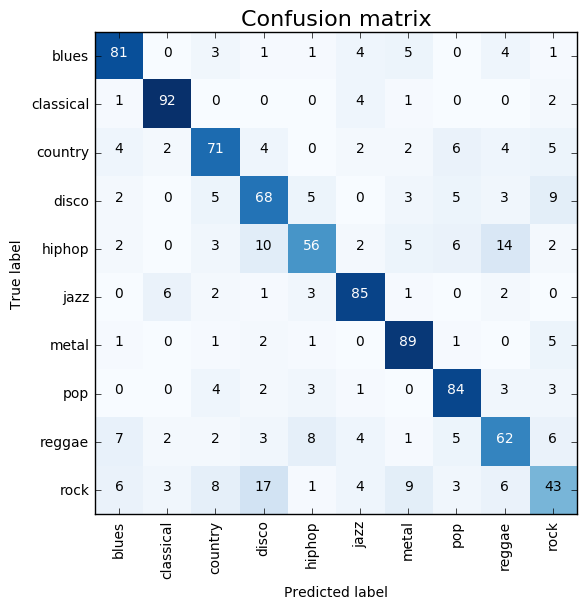

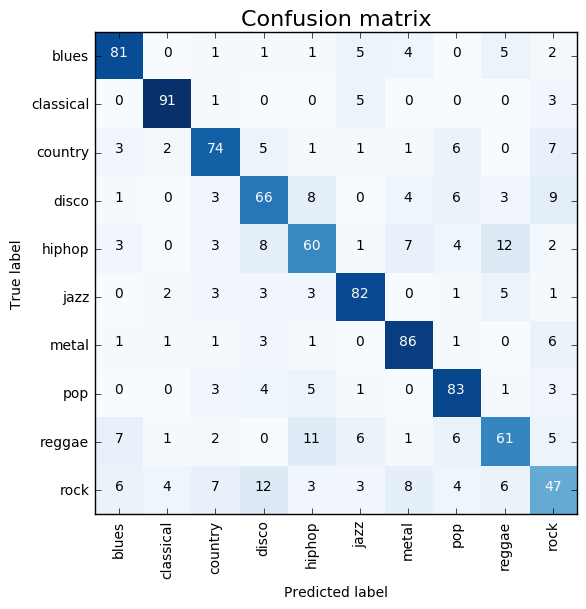

In [113]:
# le - label encoder fit previously
plot_confusion_matrix(classification_results["ssd"], le)
plot_confusion_matrix(classification_results_fusion[('ssd',)], le)

### Conclusions

Write your conclusions here...
write a paragraph where you summarize the conclusions of the classification experiments
  * which feature-set/feature-set-combinations perform best?
  * for which classes are they performing best?
  * which classes are confused most?
  * what does this tell about the audio features?

# Similarity Retrieval / Query by example

The second part of the assignment focuses on retrieving similar songs to a given example. Content based music similarity can also be defined upon the numeric feature-space. Thus, you will use the extracted music features from the classification experiments, but now you will implement a late fusion approach. The problem with early fusion is that results will skew towards features-sets with higher dimensionality. Late fusion represents a convenient method to overcome this problem by combining the result-spaces instead of the feature-spaces. For each feature first the similarities are calculated separately and then aggregated into a final estimation. Thus, every feature has an equal influence on the final result.

**Normalization**

Just like for the classification experiments the feature-spaces first need to be normalized. 

* iterate over all feature-sets
* use the *StandardScaler* as above, but because there are no train/test-splits, fit the scaler using all instances of a feature-set, and finally perform the transformation
* you can overwrite the extracted *audio_features*; their original values are not required further.

In [114]:
# Late fusion approah
audio_features_scaled = {}
# iterate over all feature-sets
print audio_features.keys()
pbar = progressbar.ProgressBar()
for feature_name in pbar(audio_features.keys()):
    # there are no train/test-splits
    X = audio_features[feature_name]
    # fit the StandardScaler using all instances of a feature-set
    sc = StandardScaler()
    sc.fit(X)
    # finally perform the transformation
    audio_features_scaled[feature_name] = sc.transform(X)

['ssd', 'rp', 'chroma', 'mfcc']


100% |########################################################################|


**Implement a query-by-example system:**

* define a *query_id* variable. This represents the index into the feature-space. The feature-vector with the corresponding id will be used to find similar songs.
* define a list of feature-set names. This is equivalent to the feature combinations you have implemented for the classification experiments.
* define a corresponding list of feature-weights. Usually weights scale from 0.0 to 1.0 and represent the influence of a feature-set on the final result.
* for each feature-set of the specified feature-set combination:
  * calculate the Eucledian-distance from the query-feature-vector to every other vector of a feature-set:

$$
\sum \sqrt{(audio\_features[feature\_name] - audio\_features[feature\_name][query\_id])^{2}}
$$

  * this will result in a distance value for each feature-vector representing the dis-similarity to the query-vector.
  * due to variances in dimensionality and value-ranges these distances vary between the feature-sets. To normalize the impact of a distinct feature-set in a late-fusion approach, you have to normalize each resulting distance-list by dividing it by its maximum value.
  * multiply each normalized distance-list with its corresponding feature-weight
  * calculate the sum of the weighted distance-lists
  * finally, use apply numpy function *argsort* on the final results to get the indexes to the feature-vectors ranked by their ascending summed distances. Thus, the top results have the lowest distance/dis-similarity to the query-vector and are expected to sound similar to the query-song.
  * use our provided method to display the retrieval results:
  
        show_query_results(filenames, labels, ranked_index)
      
The displayed result-table contains HTML5 audio player tags. Unfortunately, most Internet browsers have a security-lock to prevent Web-pages from referencing or accessing local files. 

* To enable the playback of the audio-files, open a command-prompt and change to the root directory of the provided dataset (*AUDIO_COLLECTION_PATH*). 
* start the Python simple web-server on port 5555. This will create a simple web-server which handles requests to the local files:

        > python -m SimpleHTTPServer 5555
        

In [115]:
from sklearn.metrics.pairwise import euclidean_distances

# list of feature-weights that scale from 0.0 to 1.0 and represent 
# the influence of a feature-set on the final result.
# 'ssd', 'rp', 'chroma', 'mfcc'
feature_weights = {}
feature_weights['ssd'] = 0.25
feature_weights['rp'] = 0.25
feature_weights['chroma'] = 0.25
feature_weights['mfcc'] = 0.25
print "Feature weights:", feature_weights

def query_by_example(feature_names, trackid):
    '''
    The feature-vector with the corresponding id will be used to find similar songs.
    
    feature_names
    trackid <int> index into the feature-space
    '''
    print feature_names
    distances_sum = 0
    # calculate the Eucledian-distance from the query-feature-vector to every other vector of a feature-set
    for feature_name in feature_names:
        query_feature_vector = audio_features_scaled[feature_name][trackid]
        distances = euclidean_distances(audio_features_scaled[feature_name], query_feature_vector).flatten()

        # normalize each resulting distance-list by dividing it by its maximum value
        distances = distances / distances.max()

        #   multiply each normalized distance-list with its corresponding feature-weight
        distances = distances * feature_weights[feature_name]

        #   calculate the sum of the weighted distance-lists
        distances_sum += distances

    # finally, use apply numpy function *argsort* on the final results to get the indexes to the feature-vectors
    # ranked by their ascending summed distances. 
    # Thus, the top results have the lowest distance/dis-similarity to the query-vector and are expected to sound similar to the query-song.
    ranked_index = np.argsort(distances_sum, axis=0)
    print ranked_index
    return ranked_index


# call function with the specified trackid
# To enable the playback of the audio-files
# open a command-prompt and change to AUDIO_COLLECTION_PATH: dataset/genres/
# run: python -m SimpleHTTPServer 5555
trackid = 2
# for each feature-set of the specified feature-set combination
print "Rankings for different feature combinations"
pbar = progressbar.ProgressBar()
for feature_names in pbar(combinations):
    ranked_index = query_by_example(feature_names, trackid)

# produce the result table for the selected feature-set
feature_names = ('ssd', 'rp', 'chroma', 'mfcc')
print "Sample ranking for features:", feature_names
ranked_index = query_by_example(feature_names, trackid)
# display the retrieval results
show_query_results(filenames, labels, ranked_index)

Feature weights: {'ssd': 0.25, 'mfcc': 0.25, 'rp': 0.25, 'chroma': 0.25}
Rankings for different feature combinations
('ssd',)
[  2 906 566 344 149 153 413 318 971 281 ..., 209 836 163  89 177 155 178  93 886 180]
('rp',)
[  2  10 805 856 575  79 282 652 821 245 ..., 437 363 871 406 419 789 752 757 865 777]
('chroma',)
[  2 281 270 957 866  51 634 694 213 288 ..., 193 604 184 190 143 195 169 487 168 173]
('mfcc',)
[  2 801 356 349 389 270   0 900 360 989 ..., 839 462 701 840 154 115 192 886 753 189]
('ssd', 'rp')
[  2  10 805 566 575 282 563  67 573  70 ..., 132 752 177 757 777 155 178  93 886 180]
('ssd', 'chroma')
[  2 281 270  50 288 227  51 249 271 957 ..., 155 487 184 195 178 164 116  93 180 886]
('ssd', 'mfcc')
[  2 906   0 270 386 366 900 349 281 277 ..., 179 839 753 177 115 178 189  93 180 886]
('rp', 'chroma')
[  2 281 634 694 270 866 288 556  51 213 ..., 886 190 150 164 169 487 116 184 195 363]
('rp', 'mfcc')
[  2 821 272   0 296 900 668 975 270  70 ..., 759 871 115 757 865 70

//anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
//anaco

rank,index,filename,label,audio
0,2,./dataset/genres/blues/blues.00002.au,blues,
1,270,./dataset/genres/country/country.00070.au,country,
2,281,./dataset/genres/country/country.00081.au,country,
3,288,./dataset/genres/country/country.00088.au,country,
4,989,./dataset/genres/rock/rock.00089.au,rock,
5,386,./dataset/genres/disco/disco.00086.au,disco,
6,50,./dataset/genres/blues/blues.00050.au,blues,
7,282,./dataset/genres/country/country.00082.au,country,
8,284,./dataset/genres/country/country.00084.au,country,
9,283,./dataset/genres/country/country.00083.au,country,


* Experiment with different feature-set combinations and feature-weights using different query-songs.
* show two good and two bad performing examples using the *show_query_results* function
* write a paragraph where you summarize the conclusions of the query-by-example experiments
  * which feature-sets are performing best and why?
  * listening to the results, what is the perceived quality?
    * in which terms do the top-ranked results sound similar
    * are there songs that do not fit at all?
    * do they at least share some acoustic similarity with the query-song (e.g. rhythm, instrumentation, pitch, etc.)?
  * compare the query-by-example precision with the classification confusion-matrix for the corresponding feature-set-combination. Are the top confusions also predominant mismatches within the top-ranked retrieval results?

### Conclusions

Write your conclusions here...

summarize the conclusions of the query-by-example experiments
which feature-sets are performing best and why?
listening to the results, what is the perceived quality?
in which terms do the top-ranked results sound similar
are there songs that do not fit at all?
do they at least share some acoustic similarity with the query-song (e.g. rhythm, instrumentation, pitch, etc.)?
compare the query-by-example precision with the classification confusion-matrix for the corresponding feature-set-combination. Are the top confusions also predominant mismatches within the top-ranked retrieval results?